In [ ]:
from google.colab import drive
drive.mount('/content/drive')

su2_path = '/content/drive/My Drive/SU2/'



Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.python.client import device_lib

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Reshape,
    Multiply, DepthwiseConv2D, GlobalAveragePooling2D, LeakyReLU, ReLU, SeparableConv2D
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score, classification_report
import pandas as pd
import pickle

!pip install optuna
import optuna
!pip install optuna-integration[tfkeras]
from optuna.integration import TFKerasPruningCallback

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Detailed Device Information:")
print(device_lib.list_local_devices())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 9.4 MB/s eta 0:00:00
TensorFlow version: 2.17.1
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
Detailed Device Information:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7387380860652229676
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21991653376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14663046895250618085
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [ ]:
def preprocess_and_augment(image, label, is_train=True, num_classes=37):
    image = tf.cast(image, tf.float32)

    if is_train:
      if tf.random.uniform(()) > 0.5:
          image = tf.image.random_flip_left_right(image)
      if tf.random.uniform(()) > 0.5:
          image = tf.image.random_flip_up_down(image)
      if tf.random.uniform(()) > 0.5:
          image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
      if tf.random.uniform(()) > 0.5:
          image = tf.image.random_brightness(image, max_delta=0.01)
      if tf.random.uniform(()) > 0.5:
          image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
      if tf.random.uniform(()) > 0.5:
          image = tf.image.random_hue(image, max_delta=0.01)
      if tf.random.uniform(()) > 0.5:
          image = tf.image.rot90(image, k=tf.random.uniform([], 0, 2, dtype=tf.int32))

   # image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.BILINEAR)

    image = tf.image.resize_with_pad(
        image,
        target_height=224,
        target_width=224,
        method=tf.image.ResizeMethod.BILINEAR
    )

    image = image / 255.0
    #image = (image / 127.5) - 1.0
    image = tf.clip_by_value(image, 0.0, 1.0)

    label = tf.one_hot(label, depth=num_classes)

    return image, label


def preprocess(image, label, num_classes=37):
    image = tf.cast(image, tf.float32)

    image = tf.image.resize_with_pad(
        image,
        target_height=224,
        target_width=224,
        method=tf.image.ResizeMethod.BILINEAR
    )

    image = image / 255.0
    #image = (image / 127.5) - 1.0
    image = tf.clip_by_value(image, 0.0, 1.0)

    label = tf.one_hot(label, depth=num_classes)

    return image, label

def plot_images(original_image, processed_image, label, class_names):
    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.numpy())
    plt.title(f"Original Image (Label: {class_names[label]})")
    plt.axis('off')

    # Plot processed image
    plt.subplot(1, 2, 2)
    plt.imshow(processed_image.numpy())
    plt.title(f"Processed Image (Label: {class_names[label]})")
    plt.axis('off')

    plt.show()



def plot_history(history):
    sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    axs[0].plot(history.history['loss'],
                label='Training Loss',
                color=sns.color_palette("tab10")[0],
                marker='o',
                linewidth=2,
                markersize=6)

    axs[0].plot(history.history['val_loss'],
                label='Validation Loss',
                color=sns.color_palette("tab10")[1],
                marker='s',
                linewidth=2,
                markersize=6,
                linestyle='--')

    axs[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=20)
    axs[0].set_xlabel('Epochs', fontsize=12, labelpad=10)
    axs[0].set_ylabel('Loss', fontsize=12, labelpad=10)
    axs[0].legend(loc="best", fontsize=10, frameon=True, facecolor='white', edgecolor='gray', shadow=True)
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].tick_params(labelsize=10)

    axs[1].plot(history.history['accuracy'],
                label='Training Accuracy',
                color=sns.color_palette("tab10")[2],
                marker='o',
                linewidth=2,
                markersize=6)

    axs[1].plot(history.history['val_accuracy'],
                label='Validation Accuracy',
                color=sns.color_palette("tab10")[3],
                marker='s',
                linewidth=2,
                markersize=6,
                linestyle='--')

    axs[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=20)
    axs[1].set_xlabel('Epochs', fontsize=12, labelpad=10)
    axs[1].set_ylabel('Accuracy', fontsize=12, labelpad=10)
    axs[1].legend(loc="best", fontsize=10, frameon=True, facecolor='white', edgecolor='gray', shadow=True)
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()



def plot_history_from_dict(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()



def predict_on_real_data( model, label_names, model_name):
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)

    image_paths = [
    su2_path + "testne_slike/siamese_cat_test.jpg",
    su2_path + "testne_slike/ragdoll_test.jpg"
    ]
    correct_labels = ["Siamese Cat", "Ragdoll"]

    for image_path, correct_label in zip(image_paths, correct_labels):
        img_orig = tf.keras.preprocessing.image.load_img(image_path)
        img_processed, _ = preprocess(img_orig, 1)
        img_batch = np.expand_dims(img_processed, axis=0)

        predictions = model.predict(img_batch)[0]
        top_indices = np.argsort(predictions)[::-1][:3]
        top_predictions = [(label_names[i], predictions[i] * 100) for i in top_indices]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})


        ax1.imshow(img_processed)
        ax1.set_title(
            f"{model_name} - Processed Image\nCorrect Label: {correct_label}",
            fontweight='bold',
            fontsize=10
        )
        ax1.axis('off')

        pred_names, pred_values = zip(*top_predictions)
        sns.barplot(
            x=list(pred_values),
            y=list(pred_names),
            ax=ax2,
            orient="h",
            hue=list(pred_names),
            dodge=False,
            legend=False
        )
        ax2.set_xlim(0, 100)
        ax2.set_xlabel("Confidence (%)", fontsize=12)
        ax2.set_title("Top Predictions", fontweight='bold', fontsize=14)
        ax2.tick_params(axis='y', labelsize=12)
        ax2.tick_params(axis='x', labelsize=10)

        plt.tight_layout()
        sns.despine(left=True, bottom=True)
        plt.show()


In [ ]:
train_dir = "/content/drive/My Drive/SU2/images_main/train"
test_dir = "/content/drive/My Drive/SU2/images_main/test"

train_dataset_orig = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="int",
    batch_size=None
)

test_dataset_orig = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="int",
    batch_size=None
)

print(f"Validation dataset batches: {tf.data.experimental.cardinality(train_dataset_orig).numpy()}")

print(f"Validation dataset batches: {tf.data.experimental.cardinality(test_dataset_orig).numpy()}")


for image, label in train_dataset_orig.take(1):  # Example: Check 5 samples
    print(f"Image shape: {image.shape}, Label: {label}")

Found 4776 files belonging to 37 classes.
Found 2573 files belonging to 37 classes.
Validation dataset batches: 4776
Validation dataset batches: 2573
Image shape: (256, 256, 3), Label: 32


In [ ]:
BATCH_SIZE = 32

test_size = len(test_dataset_orig) // 2
val_dataset = test_dataset_orig.take(test_size)
test_dataset = test_dataset_orig.skip(test_size)


train_dataset = (
    train_dataset_orig
    .repeat(5)
    .map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(333)
    .batch(BATCH_SIZE)
)

val_dataset = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
)

test_dataset = (
    test_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
)


print(f"Training dataset batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation dataset batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Testing dataset batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")




Training dataset batches: 747
Validation dataset batches: 41
Testing dataset batches: 41


In [ ]:
labels = np.concatenate([
    np.argmax(label_batch, axis=1) for _, label_batch in train_dataset
])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = {int(class_idx): weight for class_idx, weight in zip(np.unique(labels), class_weights)}


print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.040976460331299, 1: 0.9491255961844197, 2: 0.963291649858814, 3: 1.2063652437484214, 4: 0.992931392931393, 5: 1.0939074667888227, 6: 0.9705344442186548, 7: 1.008445945945946, 8: 0.9561561561561561, 9: 1.0756756756756756, 10: 1.040976460331299, 11: 1.008445945945946, 12: 1.0667857940585213, 13: 0.922007722007722, 14: 1.0244530244530246, 15: 1.0667857940585213, 16: 1.016386465205363, 17: 1.040976460331299, 18: 1.0006285355122564, 19: 0.9491255961844197, 20: 0.8381888381888382, 21: 1.0006285355122564, 22: 1.0006285355122564, 23: 0.992931392931393, 24: 0.9853517639777182, 25: 1.0006285355122564, 26: 0.992931392931393, 27: 1.016386465205363, 28: 0.9561561561561561, 29: 1.016386465205363, 30: 0.992931392931393, 31: 1.008445945945946, 32: 1.0244530244530246, 33: 0.9421976721246794, 34: 1.008445945945946, 35: 0.9154686601495112, 36: 1.040976460331299}


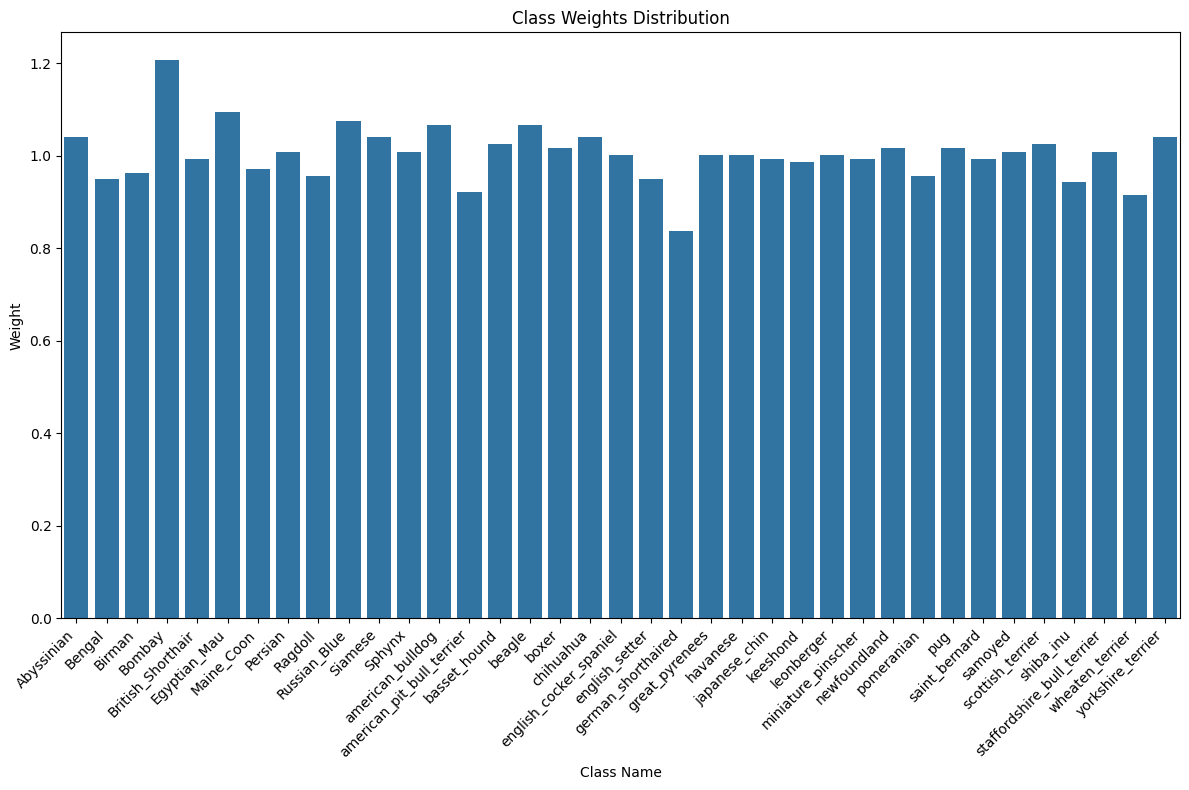

In [ ]:
label_names = test_dataset_orig.class_names


mapped_weights = {label_names[key]: value for key, value in class_weights_dict.items()}

plt.figure(figsize=(12, 8))
sns.barplot(
    x=list(mapped_weights.keys()),
    y=list(mapped_weights.values())
)
plt.title("Class Weights Distribution")
plt.xlabel("Class Name")
plt.ylabel("Weight")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

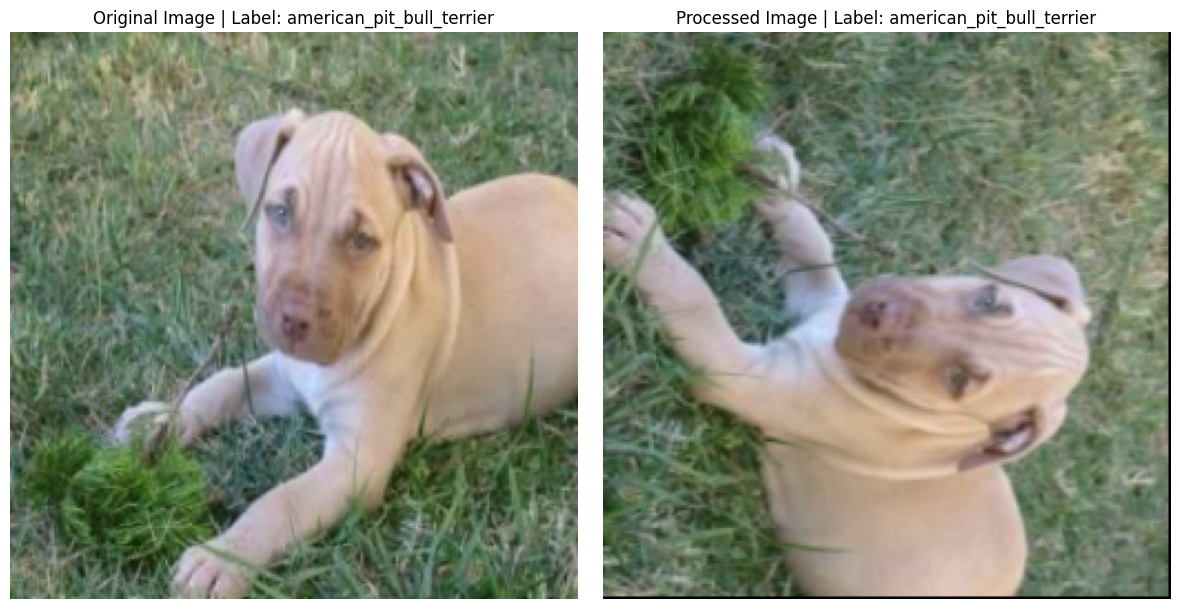

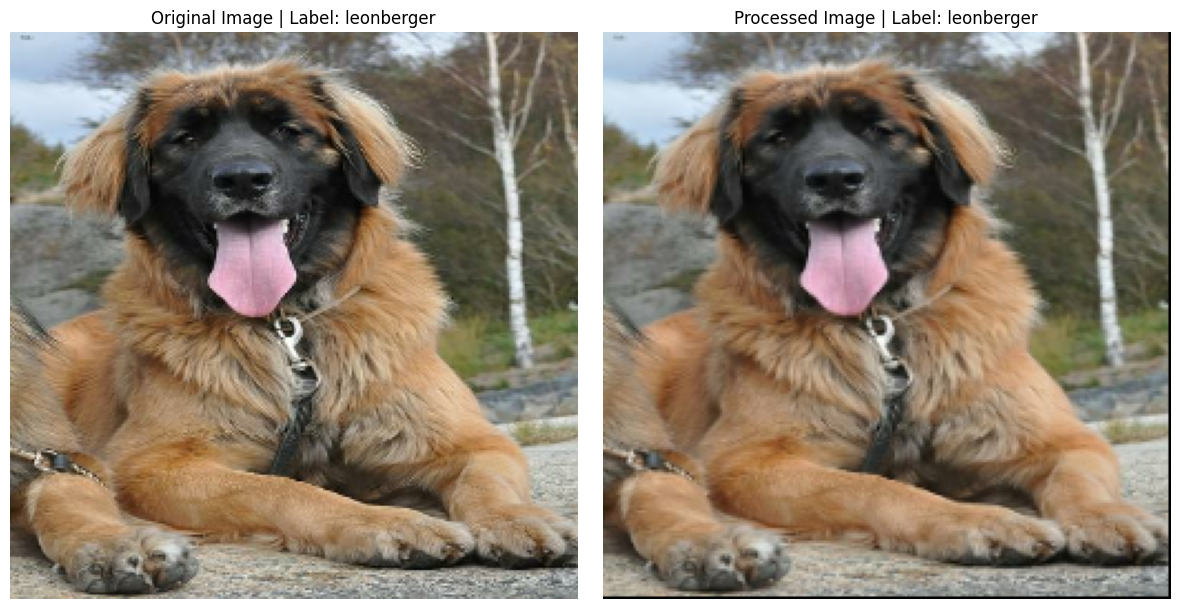

In [ ]:
for image, label in train_dataset_orig.take(2):

    image = image.numpy()
    label = label.numpy()

    label_index = label

    class_name = label_names[label_index]

    processed_image, _ = preprocess_and_augment(image, label)
    processed_image = processed_image.numpy()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Original Image | Label: {class_name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image)

    plt.title(f"Processed Image | Label: {class_name}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# **LE-NET-5**

In [ ]:
def build_lenet5(input_shape=(224, 224, 3), num_classes=1, learning_rate=1e-3, drop_rate=0.5, l1=1e-4, l2=1e-4):
    kernel_initializer = GlorotUniform()
    regularizer = l1_l2(l1=l1, l2=l2)

    input_layer = Input(shape=input_shape)

    x = Conv2D(filters=6, kernel_size=(7, 7), strides=1, activation="tanh",
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(input_layer)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)


    x = Conv2D(filters=16, kernel_size=(5, 5), strides=1, activation="tanh",
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    x = Flatten()(x)

    x = Dense(units=256, activation="tanh",
              kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Dropout(drop_rate)(x)
    x = Dense(units=84, activation="tanh",
              kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Dropout(drop_rate)(x)

    output_layer = Dense(units=num_classes, activation="softmax",
                         kernel_initializer=kernel_initializer)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [ ]:
model_lenet_5 = build_lenet5(
    input_shape=(224, 224, 3),
    num_classes=37,
    drop_rate=0.1143536431907607,
    learning_rate=0.001225388021788707,
    l1=1.8503409039226655e-06,
    l2=0.0007957641882232132,
)

model_lenet_5.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 218, 218, 6)         │             888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 109, 109, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 105, 105, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 52, 52, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │      11,075,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 84)                  │          21,588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 37)                  │           3,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,103,877 (42.36 MB)

 Trainable params: 11,103,877 (42.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0285 - loss: 3.9454 - val_accuracy: 0.0295 - val_loss: 3.9751 - learning_rate: 6.1269e-04
Epoch 2/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0239 - loss: 3.9643 - val_accuracy: 0.0233 - val_loss: 3.7899 - learning_rate: 6.1269e-04
Epoch 3/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0251 - loss: 3.8739 - val_accuracy: 0.0280 - val_loss: 3.8463 - learning_rate: 6.1269e-04
Epoch 4/500
745/747 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0247 - loss: 3.8284
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00030634700669907033.
747/747 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0247 - loss: 3.8284 - val_accuracy: 0.0295 - val_loss: 3.7563 - learning_rate: 6.1269e-04
Epoch 5/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0279 - loss: 3.7443 - val_accuracy: 0.0272 - val_loss: 3.6991 - learning_rate: 3.0635e-04
Epoch 6/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/st

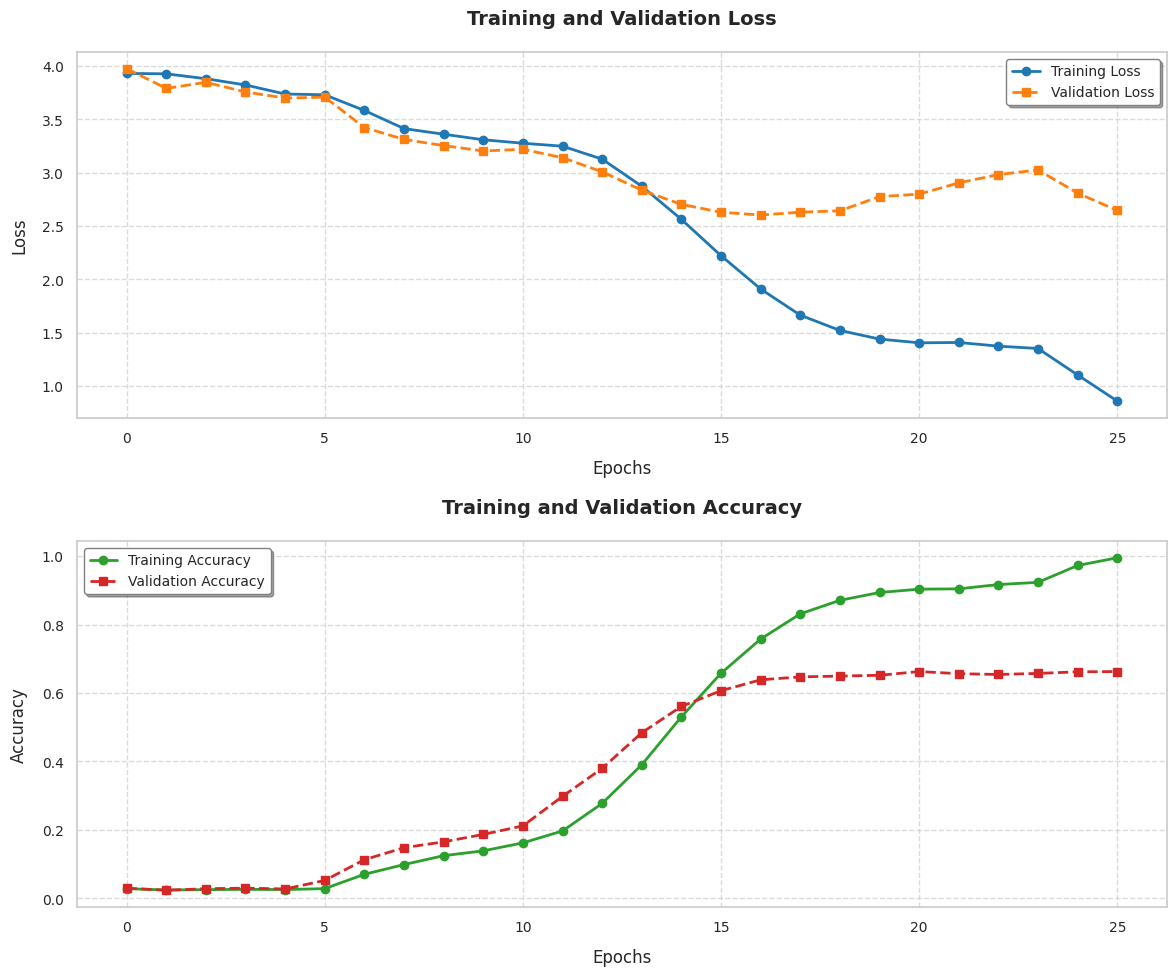

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)


history_model_lenet_5 = model_lenet_5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict,
)

plot_history(history_model_lenet_5)


In [ ]:
test_loss, test_accuracy = model_lenet_5.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6595 - loss: 2.7506
Test Loss: 2.841474771499634
Test Accuracy: 0.6464646458625793


In [ ]:
save_dir = '/content/drive/My Drive/SU2/models'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_lenet5.keras')
model_lenet_5.save(model_path)

history_path = os.path.join(save_dir, 'history_model_lenet5.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history_model_lenet_5.history, file)


# **SIMPLE CNN 1**

In [ ]:
def build_simple_cnn_1(input_shape=(224, 224, 3), num_classes=37, dropout_rate=0.428, learning_rate=8.213e-5, l1=5.532e-10, l2=5.125e-7, alpha=0.1):
    inputs = Input(shape=input_shape)

    x = Conv2D(8, (3, 3), kernel_initializer=HeNormal(seed=42), padding="same", kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(16, (3, 3), kernel_initializer=HeNormal(seed=42), padding="same", kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), kernel_initializer=HeNormal(seed=42), padding="same", kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), kernel_initializer=HeNormal(seed=42), padding="same", kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), kernel_initializer=HeNormal(seed=42), padding="same", kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), kernel_initializer=HeNormal(seed=42), padding="same", kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(256, kernel_initializer=HeNormal(seed=42), kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    outputs = Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform(seed=0))(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
def objective(trial):
    drop_rate = trial.suggest_float("drop_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-2)
    l1 = trial.suggest_float("l1", 1e-6, 1e-3, log=True)
    l2 = trial.suggest_float("l2", 1e-6, 1e-3, log=True)
    alpha = trial.suggest_float("alpha", 0.01, 0.3)


    model_cnn_simple = build_simple_cnn_1(
        input_shape=(224, 224, 3),
        num_classes=37,
        dropout_rate=drop_rate,
        learning_rate=learning_rate,
        l1=l1,
        l2=l2,
        alpha=alpha
    )
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)

    history = model_cnn_simple.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[early_stopping, reduce_lr],
        verbose=0,
        class_weight=class_weights_dict,
    )

    return max(history.history["val_accuracy"])


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-12-14 17:26:28,875] A new study created in memory with name: no-name-6760a856-a866-4247-a262-d9c1ee7dac4e
<ipython-input-35-a546579c8109>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-2)



Epoch 24: ReduceLROnPlateau reducing learning rate to 2.2362628442351706e-05.


[I 2024-12-14 17:31:46,477] Trial 0 finished with value: 0.12208398431539536 and parameters: {'drop_rate': 0.3222491425307925, 'learning_rate': 4.472525717227788e-05, 'l1': 1.887105039276095e-05, 'l2': 0.00023029912336529934, 'alpha': 0.29023429499198855}. Best is trial 0 with value: 0.12208398431539536.



Epoch 12: ReduceLROnPlateau reducing learning rate to 1.4116378224571235e-05.


[I 2024-12-14 17:34:50,822] Trial 1 finished with value: 0.09564541280269623 and parameters: {'drop_rate': 0.31765410512104875, 'learning_rate': 2.8232757113479366e-05, 'l1': 0.00021575415907951345, 'l2': 9.835630520112636e-06, 'alpha': 0.19582684664032995}. Best is trial 0 with value: 0.12208398431539536.



Epoch 29: ReduceLROnPlateau reducing learning rate to 1.6873690356078441e-06.

Epoch 36: ReduceLROnPlateau reducing learning rate to 8.436845178039221e-07.


[I 2024-12-14 17:42:25,352] Trial 2 finished with value: 0.06842923909425735 and parameters: {'drop_rate': 0.274903467493656, 'learning_rate': 3.3747380572459953e-06, 'l1': 1.1480290050577884e-05, 'l2': 5.9774466562727315e-06, 'alpha': 0.23302419285453913}. Best is trial 0 with value: 0.12208398431539536.



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007221167907118797.


[I 2024-12-14 17:44:06,478] Trial 3 finished with value: 0.08631414920091629 and parameters: {'drop_rate': 0.460787479098581, 'learning_rate': 0.0014442335256782638, 'l1': 3.5451996416768393e-06, 'l2': 7.880675697568846e-05, 'alpha': 0.2335204973047676}. Best is trial 0 with value: 0.12208398431539536.



Epoch 16: ReduceLROnPlateau reducing learning rate to 2.7887481337529607e-05.


[I 2024-12-14 17:47:52,915] Trial 4 finished with value: 0.12674960494041443 and parameters: {'drop_rate': 0.3264427556391971, 'learning_rate': 5.577496206108816e-05, 'l1': 4.1283713763091015e-05, 'l2': 1.3034213396842578e-05, 'alpha': 0.15214171225327333}. Best is trial 4 with value: 0.12674960494041443.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002672491245903075.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00013362456229515374.

Epoch 17: ReduceLROnPlateau reducing learning rate to 6.681228114757687e-05.

Epoch 28: ReduceLROnPlateau reducing learning rate to 3.3406140573788434e-05.

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.6703070286894217e-05.

Epoch 42: ReduceLROnPlateau reducing learning rate to 8.351535143447109e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 4.175767571723554e-06.


[I 2024-12-14 17:57:20,486] Trial 5 finished with value: 0.6944012641906738 and parameters: {'drop_rate': 0.15075901321298715, 'learning_rate': 0.0005344982227244632, 'l1': 4.478532325368581e-05, 'l2': 0.0008229349795543498, 'alpha': 0.11577071957840532}. Best is trial 5 with value: 0.6944012641906738.



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00015553786943200976.


[I 2024-12-14 17:59:58,592] Trial 6 finished with value: 0.14152410626411438 and parameters: {'drop_rate': 0.35669429638943895, 'learning_rate': 0.00031107572476303367, 'l1': 6.204475167857547e-05, 'l2': 2.911923445217623e-05, 'alpha': 0.2809310879744563}. Best is trial 5 with value: 0.6944012641906738.



Epoch 20: ReduceLROnPlateau reducing learning rate to 3.3598773825360695e-06.

Epoch 38: ReduceLROnPlateau reducing learning rate to 1.6799386912680347e-06.


[I 2024-12-14 18:07:54,979] Trial 7 finished with value: 0.09875582903623581 and parameters: {'drop_rate': 0.2602611417244135, 'learning_rate': 6.719754625083634e-06, 'l1': 6.068755308048791e-06, 'l2': 1.1829897729910149e-06, 'alpha': 0.12413733789085649}. Best is trial 5 with value: 0.6944012641906738.



Epoch 18: ReduceLROnPlateau reducing learning rate to 3.8787289668107405e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.9393644834053703e-05.

Epoch 31: ReduceLROnPlateau reducing learning rate to 9.696822417026851e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 4.848411208513426e-06.


[I 2024-12-14 18:16:02,584] Trial 8 finished with value: 0.214618980884552 and parameters: {'drop_rate': 0.23774674560841766, 'learning_rate': 7.757458061647571e-05, 'l1': 0.00041020772799114073, 'l2': 0.000117467018789658, 'alpha': 0.024182555011250908}. Best is trial 5 with value: 0.6944012641906738.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0031191911548376083.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0015595955774188042.


[I 2024-12-14 18:21:08,167] Trial 9 finished with value: 0.20373250544071198 and parameters: {'drop_rate': 0.192709002757972, 'learning_rate': 0.00623838235730804, 'l1': 0.0004893908863154938, 'l2': 2.3482680727192604e-06, 'alpha': 0.056159483324941736}. Best is trial 5 with value: 0.6944012641906738.



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0010030794655904174.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005015397327952087.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.00025076986639760435.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00012538493319880217.


[I 2024-12-14 18:28:07,686] Trial 10 finished with value: 0.8125972151756287 and parameters: {'drop_rate': 0.11307538939702858, 'learning_rate': 0.0020061589617793242, 'l1': 1.342241477598186e-06, 'l2': 0.0009544632163523419, 'alpha': 0.08572355004711345}. Best is trial 10 with value: 0.8125972151756287.



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0003636007022578269.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.00018180035112891346.

Epoch 34: ReduceLROnPlateau reducing learning rate to 9.090017556445673e-05.

Epoch 39: ReduceLROnPlateau reducing learning rate to 4.5450087782228366e-05.

Epoch 47: ReduceLROnPlateau reducing learning rate to 2.2725043891114183e-05.


[I 2024-12-14 18:37:58,162] Trial 11 finished with value: 0.8141524195671082 and parameters: {'drop_rate': 0.10354012641219841, 'learning_rate': 0.0007272013844623731, 'l1': 1.2806702558267472e-06, 'l2': 0.0006441411005474748, 'alpha': 0.09334212524261747}. Best is trial 11 with value: 0.8141524195671082.



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.004845635965466499.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0024228179827332497.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0012114089913666248.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0006057044956833124.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0003028522478416562.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001514261239208281.

Epoch 50: ReduceLROnPlateau reducing learning rate to 7.571306196041405e-05.


[I 2024-12-14 18:47:47,331] Trial 12 finished with value: 0.5443235039710999 and parameters: {'drop_rate': 0.10678123567756387, 'learning_rate': 0.009691272012627209, 'l1': 1.0248091520248592e-06, 'l2': 0.000692278424180901, 'alpha': 0.07828492565990941}. Best is trial 11 with value: 0.8141524195671082.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0009165811352431774.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0004582905676215887.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00022914528381079435.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00011457264190539718.

Epoch 33: ReduceLROnPlateau reducing learning rate to 5.728632095269859e-05.

Epoch 38: ReduceLROnPlateau reducing learning rate to 2.8643160476349294e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.4321580238174647e-05.

Epoch 47: ReduceLROnPlateau reducing learning rate to 7.1607901190873235e-06.


[I 2024-12-14 18:57:26,614] Trial 13 finished with value: 0.8273717164993286 and parameters: {'drop_rate': 0.1024364334441637, 'learning_rate': 0.0018331622673113156, 'l1': 1.352798482373886e-06, 'l2': 0.0003302120051016458, 'alpha': 0.08688925100641263}. Best is trial 13 with value: 0.8273717164993286.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001592212065588683.


[I 2024-12-14 19:00:27,714] Trial 14 finished with value: 0.2682737112045288 and parameters: {'drop_rate': 0.20616093208966751, 'learning_rate': 0.0003184424176930437, 'l1': 2.547720600707689e-06, 'l2': 0.0002901527325736109, 'alpha': 0.02589498480256494}. Best is trial 13 with value: 0.8273717164993286.



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0007887514657340944.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0003943757328670472.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001971878664335236.

Epoch 31: ReduceLROnPlateau reducing learning rate to 9.85939332167618e-05.

Epoch 36: ReduceLROnPlateau reducing learning rate to 4.92969666083809e-05.


[I 2024-12-14 19:08:02,190] Trial 15 finished with value: 0.8040435314178467 and parameters: {'drop_rate': 0.17020768836950745, 'learning_rate': 0.0015775029815474093, 'l1': 7.0117114070741574e-06, 'l2': 0.0002848264253555896, 'alpha': 0.1215989963243915}. Best is trial 13 with value: 0.8273717164993286.



Epoch 6: ReduceLROnPlateau reducing learning rate to 5.039750590185577e-07.


[I 2024-12-14 19:09:54,682] Trial 16 finished with value: 0.028771383687853813 and parameters: {'drop_rate': 0.4545390218250393, 'learning_rate': 1.0079500638567981e-06, 'l1': 2.5160393321082153e-06, 'l2': 8.229243684001999e-05, 'alpha': 0.1724841661594354}. Best is trial 13 with value: 0.8273717164993286.



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00033182158949784935.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00016591079474892467.

Epoch 26: ReduceLROnPlateau reducing learning rate to 8.295539737446234e-05.

Epoch 31: ReduceLROnPlateau reducing learning rate to 4.147769868723117e-05.

Epoch 38: ReduceLROnPlateau reducing learning rate to 2.0738849343615584e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.0369424671807792e-05.

Epoch 50: ReduceLROnPlateau reducing learning rate to 5.184712335903896e-06.


[I 2024-12-14 19:19:50,983] Trial 17 finished with value: 0.7830482125282288 and parameters: {'drop_rate': 0.1295434003043788, 'learning_rate': 0.0006636431597077945, 'l1': 0.00013443478242362652, 'l2': 3.736053320260736e-05, 'alpha': 0.06231501628817736}. Best is trial 13 with value: 0.8273717164993286.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0015674603637307882.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0007837301818653941.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00039186509093269706.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00019593254546634853.

Epoch 36: ReduceLROnPlateau reducing learning rate to 9.796627273317426e-05.


[I 2024-12-14 19:27:26,099] Trial 18 finished with value: 0.5886469483375549 and parameters: {'drop_rate': 0.37173627267625237, 'learning_rate': 0.0031349206374219323, 'l1': 1.018441369174134e-06, 'l2': 0.00040708392365003615, 'alpha': 0.09231869701072556}. Best is trial 13 with value: 0.8273717164993286.



Epoch 21: ReduceLROnPlateau reducing learning rate to 8.178149437298998e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 4.089074718649499e-05.


[I 2024-12-14 19:33:40,356] Trial 19 finished with value: 0.30171072483062744 and parameters: {'drop_rate': 0.2149308445432223, 'learning_rate': 0.00016356299267042128, 'l1': 1.9283603141055354e-05, 'l2': 0.00014844136624501912, 'alpha': 0.010894705848146807}. Best is trial 13 with value: 0.8273717164993286.



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.001671551843173802.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.000835775921586901.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0004178879607934505.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00020894398039672524.


[I 2024-12-14 19:41:14,316] Trial 20 finished with value: 0.8094868063926697 and parameters: {'drop_rate': 0.15671825588688554, 'learning_rate': 0.0033431036481601393, 'l1': 4.0000798726123005e-06, 'l2': 3.645710417595941e-05, 'alpha': 0.15497161153823508}. Best is trial 13 with value: 0.8273717164993286.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0006126940133981407.


[I 2024-12-14 19:44:15,093] Trial 21 finished with value: 0.4113530218601227 and parameters: {'drop_rate': 0.11143536431907607, 'learning_rate': 0.001225388021788707, 'l1': 1.8503409039226655e-06, 'l2': 0.0007957641882232132, 'alpha': 0.09669934109250099}. Best is trial 13 with value: 0.8273717164993286.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0018967785872519016.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0009483892936259508.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0004741946468129754.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002370973234064877.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00011854866170324385.

Epoch 40: ReduceLROnPlateau reducing learning rate to 5.9274330851621926e-05.

Epoch 47: ReduceLROnPlateau reducing learning rate to 2.9637165425810963e-05.


[I 2024-12-14 19:53:54,215] Trial 22 finished with value: 0.8351477384567261 and parameters: {'drop_rate': 0.10332008519375172, 'learning_rate': 0.0037935571013850205, 'l1': 1.3380682340465012e-06, 'l2': 0.000491237352941994, 'alpha': 0.05407681121232049}. Best is trial 22 with value: 0.8351477384567261.



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.002395845949649811.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0011979229748249054.


[I 2024-12-14 19:58:49,395] Trial 23 finished with value: 0.5598756074905396 and parameters: {'drop_rate': 0.1548278605271061, 'learning_rate': 0.004791691794547781, 'l1': 6.51264618100711e-06, 'l2': 0.00047809959096656974, 'alpha': 0.05093850816032096}. Best is trial 22 with value: 0.8351477384567261.



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.000367026892490685.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001835134462453425.

Epoch 24: ReduceLROnPlateau reducing learning rate to 9.175672312267125e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 4.587836156133562e-05.

Epoch 40: ReduceLROnPlateau reducing learning rate to 2.293918078066781e-05.

Epoch 47: ReduceLROnPlateau reducing learning rate to 1.1469590390333906e-05.


[I 2024-12-14 20:08:30,094] Trial 24 finished with value: 0.7566096186637878 and parameters: {'drop_rate': 0.1819913137127301, 'learning_rate': 0.0007340537816159805, 'l1': 1.8856637466822789e-06, 'l2': 0.0001896503439940986, 'alpha': 0.043646638561281925}. Best is trial 22 with value: 0.8351477384567261.


Best Hyperparameters: {'drop_rate': 0.10332008519375172, 'learning_rate': 0.0037935571013850205, 'l1': 1.3380682340465012e-06, 'l2': 0.000491237352941994, 'alpha': 0.05407681121232049}


In [ ]:
model_cnn_simple_1 = build_simple_cnn_1(
    input_shape=(224, 224, 3),
    num_classes=37,
    dropout_rate=0.11143536431907607,
    learning_rate=0.001225388021788707,
    l1=1.8503409039226655e-06,
    l2=0.0007957641882232132,
    alpha=0.09669934109250099
)

model_cnn_simple_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 224, 224, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 470,917 (1.80 MB)

 Trainable params: 469,413 (1.79 MB)

 Non-trainable params: 1,504 (5.88 KB)

Epoch 1/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 146s 176ms/step - accuracy: 0.0781 - loss: 4.7136 - val_accuracy: 0.1244 - val_loss: 3.9343 - learning_rate: 0.0012
Epoch 2/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.1933 - loss: 3.5042 - val_accuracy: 0.1501 - val_loss: 3.6610 - learning_rate: 0.0012
Epoch 3/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.2788 - loss: 2.9914 - val_accuracy: 0.1664 - val_loss: 4.0480 - learning_rate: 0.0012
Epoch 4/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.3628 - loss: 2.6367 - val_accuracy: 0.2473 - val_loss: 3.0650 - learning_rate: 0.0012
Epoch 5/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.4306 - loss: 2.3821 - val_accuracy: 0.3087 - val_loss: 2.7873 - learning_rate: 0.0012
Epoch 6/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4843 - loss: 2.1973 - val_accuracy: 0.3142 - val_loss: 3.0552 - learning_rate: 0.0012
Epoch 7/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0

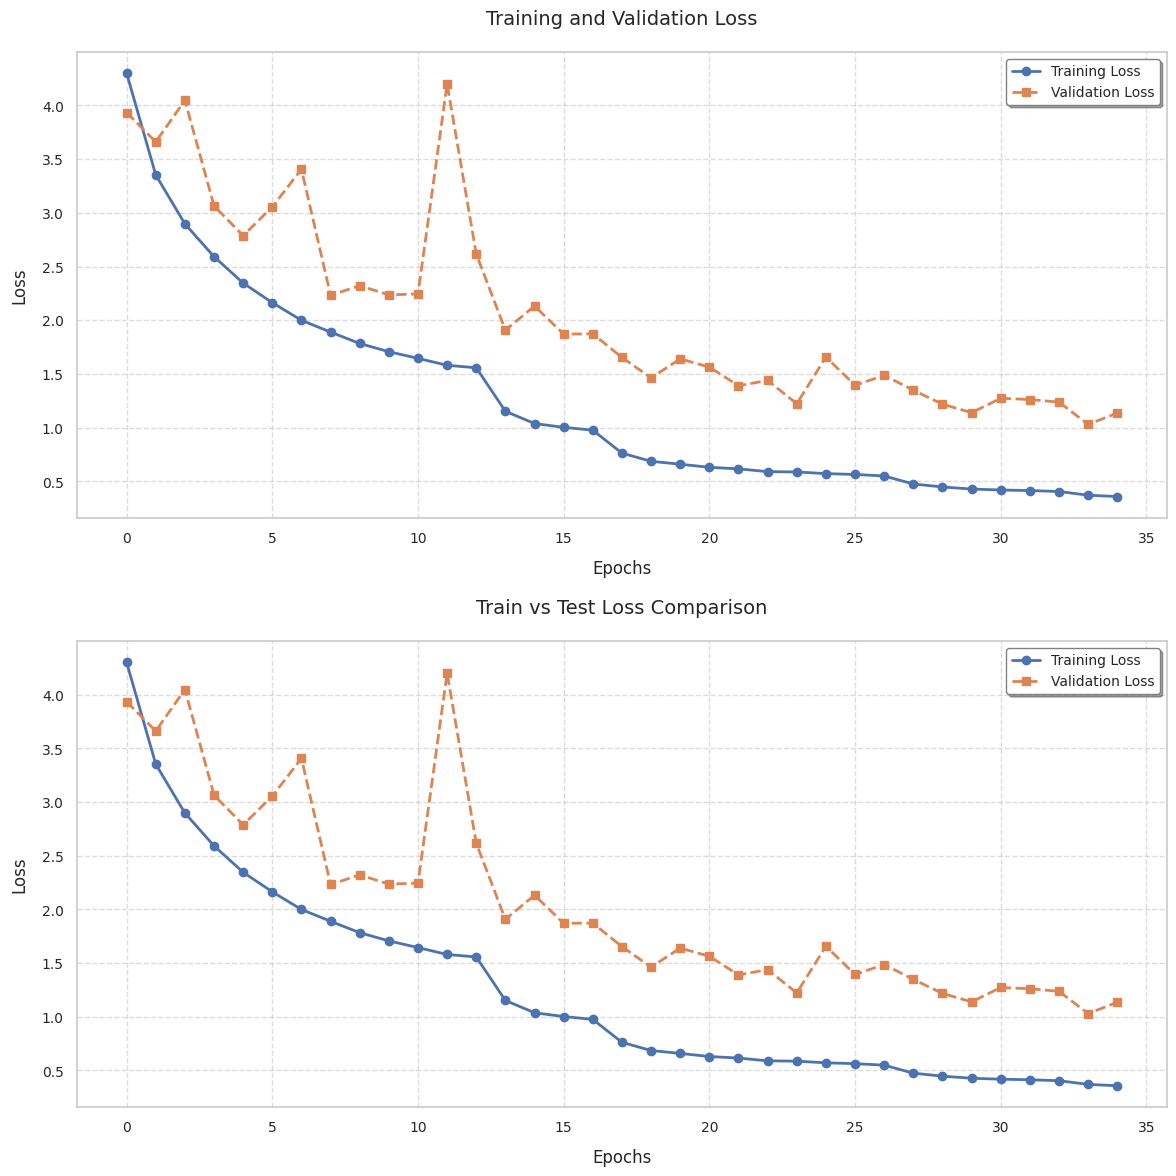

In [ ]:
model_cnn_simple_1 = build_simple_cnn_1(
    input_shape=(224, 224, 3),
    num_classes=37,
    dropout_rate=0.11143536431907607,
    learning_rate=0.001225388021788707,
    l1=1.8503409039226655e-06,
    l2=0.0007957641882232132,
    alpha=0.09669934109250099
)

early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)


history_model_cnn_simple_1 = model_cnn_simple_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict,
)

plot_history(history_model_cnn_simple_1)


In [ ]:
test_loss, test_accuracy = model_cnn_simple_1.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.8532 - loss: 1.1552
Test Loss: 1.1743525266647339
Test Accuracy: 0.8461538553237915


In [ ]:
save_dir = '/content/drive/My Drive/SU2/models'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_cnn_simple_1.keras')
model_cnn_simple_1.save(model_path)

history_path = os.path.join(save_dir, 'history_model_cnn_simple_1.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history_model_cnn_simple_1.history, file)


history_path = os.path.join(save_dir, 'history_model_cnn_simple_1.pkl')
with open(history_path, "rb") as file:
    history_loaded = pickle.load(file)




# **SIMPLE CCN 2**

In [ ]:

def build_simple_cnn_2(input_shape=(224, 224, 3), num_classes=37, dropout_rate=0.4, learning_rate=1e-4, l1=1e-8, l2=1e-6):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (5, 5), kernel_initializer=HeNormal(seed=42), kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), kernel_initializer=HeNormal(seed=42), kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (5, 5), kernel_initializer=HeNormal(seed=42), kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128, kernel_initializer=HeNormal(seed=42), kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform(seed=0))(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
model_cnn_simple_2 = build_simple_cnn_2 (
    input_shape=(224, 224, 3),
    num_classes=37,
    dropout_rate=0.2848704623176214,
    learning_rate=0.0022625288567135623,
    l1=1e-8,
    l2=0.0005790244969031276,
)

model_cnn_simple_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 220, 220, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 220, 220, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 220, 220, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 110, 110, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 108, 108, 32)        │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 108, 108, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 108, 108, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 52, 52, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 22, 22, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │              

 Total params: 248,085 (969.08 KB)

 Trainable params: 247,349 (966.21 KB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.0652 - loss: 3.9343 - val_accuracy: 0.1205 - val_loss: 3.5035 - learning_rate: 0.0023
Epoch 2/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.1388 - loss: 3.3145 - val_accuracy: 0.1182 - val_loss: 3.4810 - learning_rate: 0.0023
Epoch 3/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.1984 - loss: 3.0565 - val_accuracy: 0.2053 - val_loss: 3.1860 - learning_rate: 0.0023
Epoch 4/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2439 - loss: 2.8663 - val_accuracy: 0.1283 - val_loss: 3.8218 - learning_rate: 0.0023
Epoch 5/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2934 - loss: 2.7063 - val_accuracy: 0.1975 - val_loss: 3.2513 - learning_rate: 0.0023
Epoch 6/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.3233 - loss: 2.6003 - val_accuracy: 0.2621 - val_loss: 2.9707 - learning_rate: 0.0023
Epoch 7/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.3

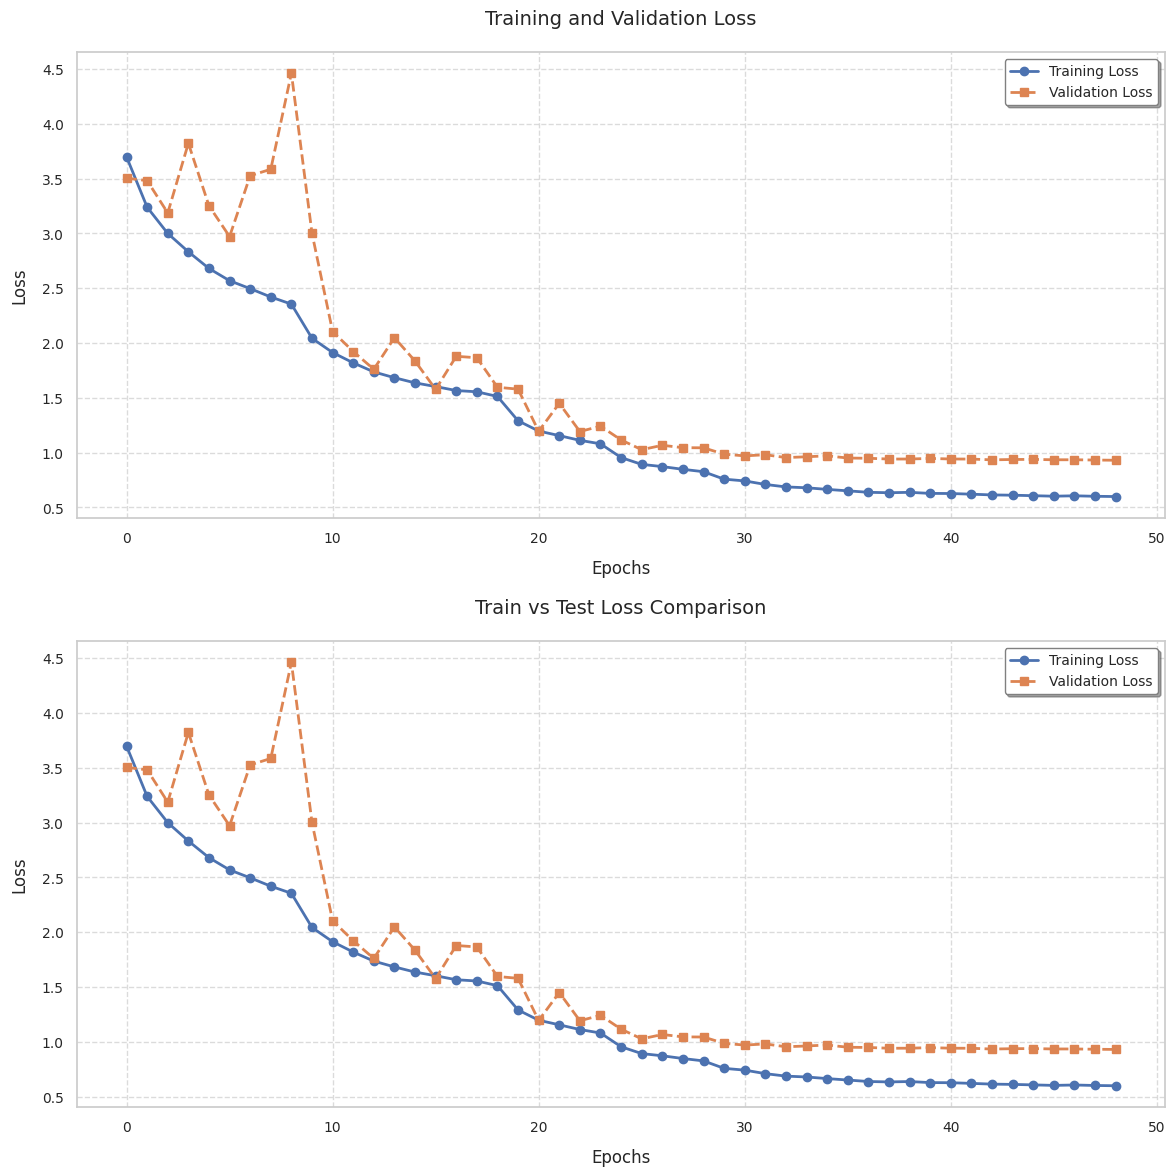

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)


history_model_cnn_simple_2 = model_cnn_simple_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict,
)

plot_history(history_model_cnn_simple_2)


In [ ]:
test_loss, test_accuracy = model_cnn_simple_2.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8631 - loss: 0.8670
Test Loss: 0.898472785949707
Test Accuracy: 0.8508158326148987


In [ ]:
save_dir = '/content/drive/My Drive/SU2/models'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_cnn_simple_2.keras')
model_cnn_simple_2.save(model_path)

history_model_cnn_simple_2_path = os.path.join(save_dir, 'history_model_cnn_simple_2.pkl')
with open(history_model_cnn_simple_2_path, "wb") as file:
    pickle.dump(history_model_cnn_simple_2.history, file)

history_model_cnn_simple_2_path = os.path.join(save_dir, 'history_model_cnn_simple_2.pkl')
with open(history_model_cnn_simple_2_path, "rb") as file:
    history_model_cnn_simple_2_loaded = pickle.load(file)


# **ALEX NET**

In [ ]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=1000,
                  dropout_rate=0.4, learning_rate=1e-3, l1=0.0, l2=0.0):
    regularizer = l1_l2(l1=l1, l2=l2)
    initializer = HeNormal(seed=42)

    inputs = Input(shape=input_shape)

    x = Conv2D(96, (11, 11), strides=(4, 4), padding="same",
               kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)


    x = Conv2D(256, (5, 5), strides=(1, 1), padding="same",
               kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = Conv2D(384, (3, 3), strides=(1, 1), padding="same",
               kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(384, (3, 3), strides=(1, 1), padding="same",
               kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)


    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same",
               kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(2048, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(2048, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation="softmax",
                    kernel_initializer=GlorotUniform(seed=0))(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def objective(trial):
    drop_rate = trial.suggest_float("drop_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2)
    l1 = trial.suggest_float("l1", 1e-6, 1e-2, log=True)
    l2 = trial.suggest_float("l2", 1e-5, 1e-3, log=True)

    model_cnn_simple = build_alexnet(
        input_shape=(224, 224, 3),
        num_classes=37,
        dropout_rate=drop_rate,
        learning_rate=learning_rate,
        l1=l1,
        l2=l2,
    )
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)

    history = model_cnn_simple.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[early_stopping, reduce_lr,pruning_callback],
        verbose=0,
        class_weight=class_weights_dict,
    )

    return max(history.history["val_accuracy"])


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-12-14 12:34:42,180] A new study created in memory with name: no-name-2aaa37cb-93ac-4fbe-bdc5-6b058794575e



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.000703747384250164.


[I 2024-12-14 12:36:59,667] Trial 0 finished with value: 0.03732503950595856 and parameters: {'drop_rate': 0.32458149406456066, 'learning_rate': 0.0014074947430885057, 'l1': 0.007736944519137533, 'l2': 0.000328386096401379}. Best is trial 0 with value: 0.03732503950595856.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005478681996464729.


[I 2024-12-14 12:39:02,558] Trial 1 finished with value: 0.0381026454269886 and parameters: {'drop_rate': 0.14546614386536288, 'learning_rate': 0.0010957363478915827, 'l1': 0.009956984652120535, 'l2': 0.0003182066275838866}. Best is trial 1 with value: 0.0381026454269886.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0021260103676468134.


[I 2024-12-14 12:41:15,048] Trial 2 finished with value: 0.03732503950595856 and parameters: {'drop_rate': 0.36546110711876734, 'learning_rate': 0.004252020841481572, 'l1': 0.009397222554268786, 'l2': 0.00020482459561165994}. Best is trial 1 with value: 0.0381026454269886.



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0018420610576868057.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0009210305288434029.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00046051526442170143.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00023025763221085072.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.00011512881610542536.


[I 2024-12-14 12:46:59,665] Trial 3 finished with value: 0.08164852112531662 and parameters: {'drop_rate': 0.3853883998168719, 'learning_rate': 0.003684122213493304, 'l1': 0.0032829624994217166, 'l2': 0.0007654323250804424}. Best is trial 3 with value: 0.08164852112531662.



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.004539318848401308.


[I 2024-12-14 12:49:23,361] Trial 4 finished with value: 0.07309486716985703 and parameters: {'drop_rate': 0.11077454625928312, 'learning_rate': 0.009078638070535168, 'l1': 0.0005520142894812341, 'l2': 0.0005334488198153057}. Best is trial 3 with value: 0.08164852112531662.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0029626619070768356.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0014813309535384178.


[I 2024-12-14 12:51:26,377] Trial 5 finished with value: 0.03421461954712868 and parameters: {'drop_rate': 0.3262426289516319, 'learning_rate': 0.005925323786715362, 'l1': 0.0021193509496664855, 'l2': 0.0006059171714895915}. Best is trial 3 with value: 0.08164852112531662.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0036965063773095608.


[I 2024-12-14 12:52:48,282] Trial 6 finished with value: 0.028771383687853813 and parameters: {'drop_rate': 0.3115671094396165, 'learning_rate': 0.007393012852480334, 'l1': 0.0031024157104171646, 'l2': 1.406854661159452e-05}. Best is trial 3 with value: 0.08164852112531662.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004226333927363157.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0021131669636815786.


[I 2024-12-14 12:55:12,365] Trial 7 finished with value: 0.030326593667268753 and parameters: {'drop_rate': 0.40363254407166393, 'learning_rate': 0.00845266814101166, 'l1': 0.002373279930014389, 'l2': 0.0008789371950965184}. Best is trial 3 with value: 0.08164852112531662.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00039025649311952293.


[I 2024-12-14 12:57:25,578] Trial 8 finished with value: 0.03188180550932884 and parameters: {'drop_rate': 0.23075606555873313, 'learning_rate': 0.0007805129872847981, 'l1': 0.003956906054719211, 'l2': 0.0009251074600769696}. Best is trial 3 with value: 0.08164852112531662.



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0008487530867569149.


[I 2024-12-14 12:58:58,321] Trial 9 finished with value: 0.04121306538581848 and parameters: {'drop_rate': 0.1688902919420333, 'learning_rate': 0.0016975062253472286, 'l1': 0.0006985331880292989, 'l2': 0.0006283254087952948}. Best is trial 3 with value: 0.08164852112531662.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.002011033007875085.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0010055165039375424.


[I 2024-12-14 13:01:52,520] Trial 10 finished with value: 0.03732503950595856 and parameters: {'drop_rate': 0.49170130232430154, 'learning_rate': 0.004022065883751938, 'l1': 0.006042643250576175, 'l2': 0.0007795038740938588}. Best is trial 3 with value: 0.08164852112531662.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.004976821132004261.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0024884105660021305.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0012442052830010653.


[I 2024-12-14 13:06:07,823] Trial 11 finished with value: 0.07387246936559677 and parameters: {'drop_rate': 0.10237327300778613, 'learning_rate': 0.009953642344701676, 'l1': 0.0005528954919487378, 'l2': 0.0007033799664950785}. Best is trial 3 with value: 0.08164852112531662.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004976964555680752.


[I 2024-12-14 13:07:30,175] Trial 12 finished with value: 0.0381026454269886 and parameters: {'drop_rate': 0.44714723104900006, 'learning_rate': 0.009953929236283864, 'l1': 0.00522136880327868, 'l2': 0.0007592132883042056}. Best is trial 3 with value: 0.08164852112531662.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0029808434192091227.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0014904217096045613.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0007452108548022807.


[I 2024-12-14 13:11:05,455] Trial 13 finished with value: 0.10419906675815582 and parameters: {'drop_rate': 0.2187354643668103, 'learning_rate': 0.005961686985502592, 'l1': 0.0001388164359496323, 'l2': 0.0007172868074401973}. Best is trial 13 with value: 0.10419906675815582.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001577728078700602.


[I 2024-12-14 13:12:28,542] Trial 14 finished with value: 0.0381026454269886 and parameters: {'drop_rate': 0.25028862498876736, 'learning_rate': 0.0031554561889344133, 'l1': 0.0040271382409670375, 'l2': 0.0009611991347357928}. Best is trial 13 with value: 0.10419906675815582.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.003027429338544607.


[I 2024-12-14 13:14:31,549] Trial 15 finished with value: 0.0381026454269886 and parameters: {'drop_rate': 0.24121117012830895, 'learning_rate': 0.006054858498051802, 'l1': 0.006470767932193549, 'l2': 0.00042256602851157096}. Best is trial 13 with value: 0.10419906675815582.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0013800821034237742.


[I 2024-12-14 13:16:24,606] Trial 16 finished with value: 0.03188180550932884 and parameters: {'drop_rate': 0.3859612236701255, 'learning_rate': 0.002760164091802067, 'l1': 0.0014975807774642227, 'l2': 0.0008050508689911272}. Best is trial 13 with value: 0.10419906675815582.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0027377568185329437.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0013688784092664719.


[I 2024-12-14 13:18:36,728] Trial 17 finished with value: 0.03732503950595856 and parameters: {'drop_rate': 0.20386746772540337, 'learning_rate': 0.005475513414902971, 'l1': 0.0037408194592658643, 'l2': 0.0005010963546509302}. Best is trial 13 with value: 0.10419906675815582.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.003664120100438595.


[I 2024-12-14 13:19:59,348] Trial 18 finished with value: 0.026438569650053978 and parameters: {'drop_rate': 0.2756919391796464, 'learning_rate': 0.007328240053218339, 'l1': 0.001691632063560007, 'l2': 0.0006495233312701401}. Best is trial 13 with value: 0.10419906675815582.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00224537355825305.


[I 2024-12-14 13:21:43,144] Trial 19 finished with value: 0.028771383687853813 and parameters: {'drop_rate': 0.42999044852969626, 'learning_rate': 0.004490747158314806, 'l1': 0.004986961260157471, 'l2': 0.0008541236157649265}. Best is trial 13 with value: 0.10419906675815582.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.003597467904910445.


[I 2024-12-14 13:23:36,273] Trial 20 finished with value: 0.03654743358492851 and parameters: {'drop_rate': 0.3520847766442942, 'learning_rate': 0.007194936014106774, 'l1': 0.0026648603547772425, 'l2': 0.0007076057689948983}. Best is trial 13 with value: 0.10419906675815582.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0014562024734914303.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0007281012367457151.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.00036405061837285757.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.00018202530918642879.

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.101265459321439e-05.


[I 2024-12-14 13:31:41,915] Trial 21 finished with value: 0.6967340707778931 and parameters: {'drop_rate': 0.10479973220720895, 'learning_rate': 0.0029124050169577246, 'l1': 6.835493274850958e-05, 'l2': 0.0007234453075633894}. Best is trial 21 with value: 0.6967340707778931.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0013806780334562063.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0006903390167281032.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0003451695083640516.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0001725847541820258.

Epoch 39: ReduceLROnPlateau reducing learning rate to 8.62923770910129e-05.

Epoch 44: ReduceLROnPlateau reducing learning rate to 4.314618854550645e-05.

Epoch 48: ReduceLROnPlateau reducing learning rate to 2.1573094272753224e-05.


[I 2024-12-14 13:40:28,227] Trial 22 finished with value: 0.7348366975784302 and parameters: {'drop_rate': 0.192834543203732, 'learning_rate': 0.002761356082568924, 'l1': 8.582355296318485e-05, 'l2': 0.0009797948428234967}. Best is trial 22 with value: 0.7348366975784302.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0011843428947031498.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005921714473515749.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00029608572367578745.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00014804286183789372.

Epoch 47: ReduceLROnPlateau reducing learning rate to 7.402143091894686e-05.


[I 2024-12-14 13:49:15,148] Trial 23 finished with value: 0.5808709263801575 and parameters: {'drop_rate': 0.17294833451949185, 'learning_rate': 0.0023686858285327465, 'l1': 0.00017555986450846998, 'l2': 0.0009529915617886533}. Best is trial 22 with value: 0.7348366975784302.



Epoch 7: ReduceLROnPlateau reducing learning rate to 2.6141378839383833e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.3070689419691917e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.535344709845958e-06.

Epoch 19: ReduceLROnPlateau reducing learning rate to 3.267672354922979e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.6338361774614896e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 8.169180887307448e-07.

Epoch 35: ReduceLROnPlateau reducing learning rate to 4.084590443653724e-07.


[I 2024-12-14 13:55:57,150] Trial 24 finished with value: 0.6959564685821533 and parameters: {'drop_rate': 0.16245324558425406, 'learning_rate': 5.228275681259638e-05, 'l1': 0.0011584867903924486, 'l2': 0.0009822730066625044}. Best is trial 22 with value: 0.7348366975784302.



Epoch 9: ReduceLROnPlateau reducing learning rate to 8.470588363707066e-05.


[I 2024-12-14 13:58:13,233] Trial 25 finished with value: 0.1143079325556755 and parameters: {'drop_rate': 0.1467830619609141, 'learning_rate': 0.00016941176026829402, 'l1': 0.0013615831290353752, 'l2': 0.0009782334102919773}. Best is trial 22 with value: 0.7348366975784302.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0011019185185432434.


[I 2024-12-14 14:00:06,495] Trial 26 finished with value: 0.0381026454269886 and parameters: {'drop_rate': 0.18879068917601036, 'learning_rate': 0.0022038370234609417, 'l1': 0.0011162082524341426, 'l2': 0.0008644595930194106}. Best is trial 22 with value: 0.7348366975784302.



Epoch 8: ReduceLROnPlateau reducing learning rate to 6.761989061487839e-05.

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.380994530743919e-05.


[I 2024-12-14 14:03:12,115] Trial 27 finished with value: 0.7169517874717712 and parameters: {'drop_rate': 0.1332320113000209, 'learning_rate': 0.00013523978833806724, 'l1': 7.469219209388246e-05, 'l2': 0.000888362044318069}. Best is trial 22 with value: 0.7348366975784302.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0016678995452821255.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0008339497726410627.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.00041697488632053137.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00020848744316026568.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.00010424372158013284.


[I 2024-12-14 14:11:58,801] Trial 28 finished with value: 0.714618980884552 and parameters: {'drop_rate': 0.12035156600827648, 'learning_rate': 0.003335799013853346, 'l1': 5.26135917961347e-05, 'l2': 0.0008478950797551783}. Best is trial 22 with value: 0.7348366975784302.



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0008290184778161347.


[I 2024-12-14 14:13:31,663] Trial 29 finished with value: 0.03732503950595856 and parameters: {'drop_rate': 0.13402475493898097, 'learning_rate': 0.0016580369598332492, 'l1': 0.008143100836443817, 'l2': 0.0008848031535718213}. Best is trial 22 with value: 0.7348366975784302.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.001748831244185567.


[I 2024-12-14 14:15:25,118] Trial 30 finished with value: 0.031104199588298798 and parameters: {'drop_rate': 0.13130759274692944, 'learning_rate': 0.0034976625988997765, 'l1': 0.0018745448852739831, 'l2': 0.0008258124035723608}. Best is trial 22 with value: 0.7348366975784302.



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.002470365259796381.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0012351826298981905.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0006175913149490952.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0003087956574745476.


[I 2024-12-14 14:24:10,562] Trial 31 finished with value: 0.35069984197616577 and parameters: {'drop_rate': 0.11669768757760336, 'learning_rate': 0.004940730492792171, 'l1': 9.417332364147142e-05, 'l2': 0.0009144565257425802}. Best is trial 22 with value: 0.7348366975784302.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.001443523564375937.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0007217617821879685.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00036088089109398425.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00018044044554699212.

Epoch 31: ReduceLROnPlateau reducing learning rate to 9.022022277349606e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 4.511011138674803e-05.

Epoch 48: ReduceLROnPlateau reducing learning rate to 2.2555055693374015e-05.


[I 2024-12-14 14:33:00,562] Trial 32 finished with value: 0.2441679686307907 and parameters: {'drop_rate': 0.1914948459157056, 'learning_rate': 0.00288704715357537, 'l1': 0.0008383834644927857, 'l2': 0.000825768449416479}. Best is trial 22 with value: 0.7348366975784302.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005060655530542135.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00025303277652710676.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00012651638826355338.

Epoch 23: ReduceLROnPlateau reducing learning rate to 6.325819413177669e-05.

Epoch 31: ReduceLROnPlateau reducing learning rate to 3.1629097065888345e-05.

Epoch 49: ReduceLROnPlateau reducing learning rate to 1.5814548532944173e-05.


[I 2024-12-14 14:41:49,568] Trial 33 finished with value: 0.5505443215370178 and parameters: {'drop_rate': 0.14944521660988042, 'learning_rate': 0.0010121311458023982, 'l1': 0.000900099097988786, 'l2': 0.0009868962473019844}. Best is trial 22 with value: 0.7348366975784302.



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0010703932493925095.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005351966246962547.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.00026759831234812737.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00013379915617406368.

Epoch 43: ReduceLROnPlateau reducing learning rate to 6.689957808703184e-05.


[I 2024-12-14 14:50:35,631] Trial 34 finished with value: 0.7021772861480713 and parameters: {'drop_rate': 0.12320116716445621, 'learning_rate': 0.002140786467911579, 'l1': 8.913242746832049e-05, 'l2': 0.00020906560272312264}. Best is trial 22 with value: 0.7348366975784302.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0011018418008461595.


[I 2024-12-14 14:52:18,608] Trial 35 finished with value: 0.03421461954712868 and parameters: {'drop_rate': 0.2670622946723854, 'learning_rate': 0.0022036835260778155, 'l1': 0.0017598914023573618, 'l2': 0.00025049629337188745}. Best is trial 22 with value: 0.7348366975784302.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006789086037315428.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003394543018657714.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001697271509328857.

Epoch 25: ReduceLROnPlateau reducing learning rate to 8.486357546644285e-05.


[I 2024-12-14 14:57:14,107] Trial 36 finished with value: 0.08709175884723663 and parameters: {'drop_rate': 0.12757417077525346, 'learning_rate': 0.0013578171718519024, 'l1': 0.0027040717567976824, 'l2': 0.00032705202155678293}. Best is trial 22 with value: 0.7348366975784302.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0018595639849081635.


[I 2024-12-14 14:59:26,605] Trial 37 finished with value: 0.03732503950595856 and parameters: {'drop_rate': 0.15518766267288528, 'learning_rate': 0.003719128034594313, 'l1': 0.008197686577495682, 'l2': 0.00012714904237684174}. Best is trial 22 with value: 0.7348366975784302.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004611130862031132.


[I 2024-12-14 15:00:48,983] Trial 38 finished with value: 0.028771383687853813 and parameters: {'drop_rate': 0.18265362828806203, 'learning_rate': 0.0009222261638703001, 'l1': 0.009208278657435256, 'l2': 0.0004204649072967988}. Best is trial 22 with value: 0.7348366975784302.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002558556152507663.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00012792780762538314.

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.396390381269157e-05.

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.1981951906345785e-05.


[I 2024-12-14 15:05:56,362] Trial 39 finished with value: 0.28304821252822876 and parameters: {'drop_rate': 0.21347821734964462, 'learning_rate': 0.0005117112151858225, 'l1': 0.0006011239847820705, 'l2': 0.00010455333175078961}. Best is trial 22 with value: 0.7348366975784302.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0009551238035783172.


[I 2024-12-14 15:08:01,682] Trial 40 finished with value: 0.028771383687853813 and parameters: {'drop_rate': 0.12587468927647907, 'learning_rate': 0.0019102476215395675, 'l1': 0.002519653368150264, 'l2': 0.0005723667733580335}. Best is trial 22 with value: 0.7348366975784302.



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0015898498240858316.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0007949249120429158.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0003974624560214579.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00019873122801072896.

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.936561400536448e-05.

Epoch 50: ReduceLROnPlateau reducing learning rate to 4.968280700268224e-05.


[I 2024-12-14 15:16:48,760] Trial 41 finished with value: 0.7270606756210327 and parameters: {'drop_rate': 0.1003604487461684, 'learning_rate': 0.003179699677481414, 'l1': 1.570605037326349e-05, 'l2': 0.00040768244562766945}. Best is trial 22 with value: 0.7348366975784302.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.002242504386231303.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0011212521931156516.


[I 2024-12-14 15:20:13,783] Trial 42 finished with value: 0.0847589448094368 and parameters: {'drop_rate': 0.10487360970421417, 'learning_rate': 0.004485008690010063, 'l1': 0.0003882394762184504, 'l2': 0.00023807768938299915}. Best is trial 22 with value: 0.7348366975784302.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0016716542886570096.


[I 2024-12-14 15:21:36,168] Trial 43 finished with value: 0.03732503950595856 and parameters: {'drop_rate': 0.14185450639811653, 'learning_rate': 0.0033433086153847147, 'l1': 0.0011403885980194816, 'l2': 0.000396669698463645}. Best is trial 22 with value: 0.7348366975784302.



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.001981626031920314.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.000990813015960157.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0004954065079800785.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00024770325399003923.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.00012385162699501961.


[I 2024-12-14 15:29:00,723] Trial 44 finished with value: 0.717729389667511 and parameters: {'drop_rate': 0.1654336647459071, 'learning_rate': 0.003963252171474443, 'l1': 2.611465009097249e-05, 'l2': 0.00016520015007675956}. Best is trial 22 with value: 0.7348366975784302.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0025961289647966623.


[I 2024-12-14 15:30:23,246] Trial 45 finished with value: 0.0381026454269886 and parameters: {'drop_rate': 0.16141653111550464, 'learning_rate': 0.00519225775549236, 'l1': 0.002167909403391193, 'l2': 1.2148562775062032e-05}. Best is trial 22 with value: 0.7348366975784302.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0020261486060917377.


[I 2024-12-14 15:31:45,527] Trial 46 finished with value: 0.03421461954712868 and parameters: {'drop_rate': 0.17283029121374935, 'learning_rate': 0.004052297023464, 'l1': 0.0006930978625079861, 'l2': 0.00012955772667768721}. Best is trial 22 with value: 0.7348366975784302.



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0032487160060554743.


[I 2024-12-14 15:34:09,178] Trial 47 finished with value: 0.057542767375707626 and parameters: {'drop_rate': 0.14341179611244126, 'learning_rate': 0.006497431826351121, 'l1': 0.0005980626932820944, 'l2': 0.0004982313484532115}. Best is trial 22 with value: 0.7348366975784302.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0024675149470567703.


[I 2024-12-14 15:36:02,112] Trial 48 finished with value: 0.030326593667268753 and parameters: {'drop_rate': 0.20161877451494337, 'learning_rate': 0.004935029661321326, 'l1': 0.0014297334839476613, 'l2': 0.00036064589990314526}. Best is trial 22 with value: 0.7348366975784302.



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0012699939543381333.


[I 2024-12-14 15:37:34,647] Trial 49 finished with value: 0.025660963729023933 and parameters: {'drop_rate': 0.11642416038056268, 'learning_rate': 0.0025399879710349574, 'l1': 0.002999860442324352, 'l2': 0.0009083784703306057}. Best is trial 22 with value: 0.7348366975784302.


Best Hyperparameters: {'drop_rate': 0.192834543203732, 'learning_rate': 0.002761356082568924, 'l1': 8.582355296318485e-05, 'l2': 0.0009797948428234967}


In [ ]:
model_alexnet = build_alexnet(
        input_shape=(224, 224, 3),
        num_classes=37,
        dropout_rate=0.5,
        learning_rate=1e-4,
        l1= 1e-3,
        l2=1e-2
    )
model_alexnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 56, 56, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 27, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 13, 13, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 13, 13, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 256)           │              

 Total params: 26,917,669 (102.68 MB)

 Trainable params: 26,906,725 (102.64 MB)

 Non-trainable params: 10,944 (42.75 KB)

Epoch 1/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.0829 - loss: 387.2144 - val_accuracy: 0.1120 - val_loss: 129.6033 - learning_rate: 1.0000e-04
Epoch 2/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1516 - loss: 101.9295 - val_accuracy: 0.1407 - val_loss: 49.6866 - learning_rate: 1.0000e-04
Epoch 3/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1594 - loss: 42.1834 - val_accuracy: 0.0544 - val_loss: 29.9722 - learning_rate: 1.0000e-04
Epoch 4/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1609 - loss: 23.4701 - val_accuracy: 0.0404 - val_loss: 21.0234 - learning_rate: 1.0000e-04
Epoch 5/500
746/747 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1649 - loss: 16.9146
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
747/747 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1649 - loss: 16.9128 - val_accuracy: 0.0599 - val_loss: 16.8303 - learning_rate: 1.0000e-04
Epoch 6/500
747/747 ━━━━━━━━━━━━━━━━━━━

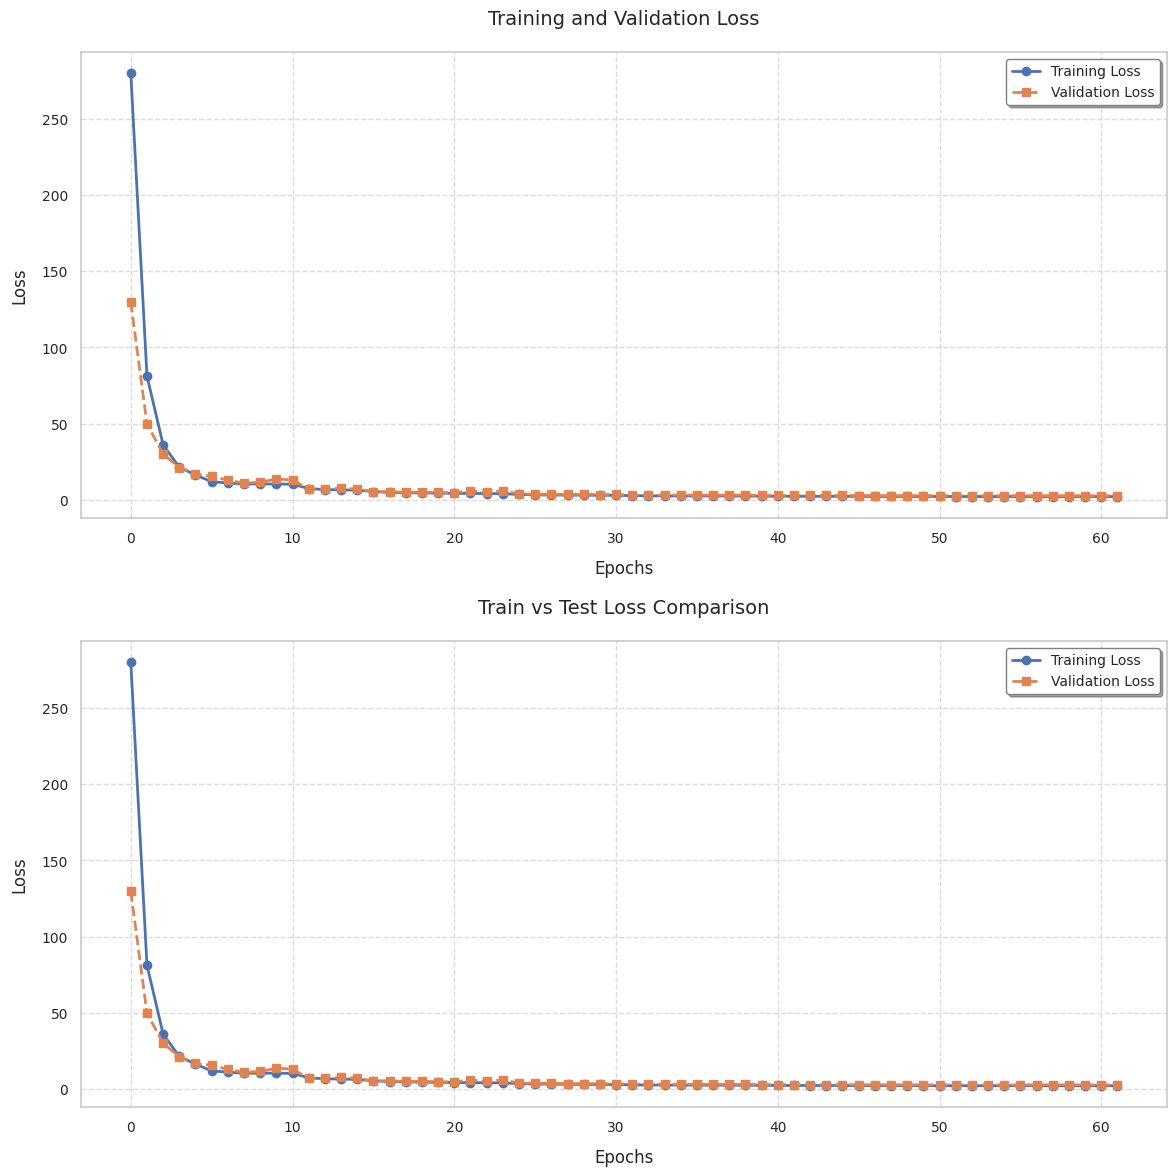

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)

history_alex_net = model_alexnet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict,
)

plot_history(history_alex_net)


In [ ]:
test_loss, test_accuracy = model_alexnet.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8146 - loss: 2.6134
Test Loss: 2.677255153656006
Test Accuracy: 0.7964258193969727


In [ ]:
save_dir = '/content/drive/My Drive/SU2/models'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'alex_net.keras')
model_alexnet.save(model_path)


history_alexnet_path = os.path.join(save_dir, 'history_alex_net.pkl')
with open(history_alexnet_path, "wb") as file:
    pickle.dump(history_alex_net.history, file)

history_alexnet_path = os.path.join(save_dir, 'history_alex_net.pkl')
with open(history_alexnet_path, "rb") as file:
    history_alexnet_loaded = pickle.load(file)


# **VVG16**

In [ ]:
def build_vgg16(input_shape=(224, 224, 3), num_classes=37, drop_rate=0.5, learning_rate=1e-4, l1=0.0, l2=1e-4):

    regularizer = l1_l2(l1=l1, l2=l2)
    kernel_initializer=HeNormal(seed=42)

    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(input_layer)
    x = Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = Conv2D(128, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = Conv2D(256, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = Flatten()(x)
    x = Dense(4096, activation='relu',
              kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Dropout(drop_rate)(x)
    x = Dense(4096, activation='relu',
              kernel_initializer=kernel_initializer, kernel_regularizer=regularizer)(x)
    x = Dropout(drop_rate)(x)
    output_layer = Dense(num_classes, activation='softmax',
                         kernel_initializer=GlorotUniform(seed=0))(x)

    model = Model(inputs=input_layer, outputs=output_layer)


    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model_VVG16 = build_vgg16(
    input_shape=(224, 224, 3),
    num_classes=37,
    drop_rate=0.45,
    learning_rate=3e-5,
    l1=1e-6,
    l2=1e-5
)

model_VVG16.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,412,133 (512.74 MB)

 Trainable params: 134,412,133 (512.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 274s 320ms/step - accuracy: 0.0399 - loss: 5.1144 - val_accuracy: 0.1485 - val_loss: 4.5177 - learning_rate: 3.0000e-05
Epoch 2/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 206s 275ms/step - accuracy: 0.1478 - loss: 4.4661 - val_accuracy: 0.2597 - val_loss: 3.9368 - learning_rate: 3.0000e-05
Epoch 3/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 207s 277ms/step - accuracy: 0.2454 - loss: 3.9855 - val_accuracy: 0.4168 - val_loss: 3.4311 - learning_rate: 3.0000e-05
Epoch 4/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 207s 277ms/step - accuracy: 0.3880 - loss: 3.4332 - val_accuracy: 0.5863 - val_loss: 2.8938 - learning_rate: 3.0000e-05
Epoch 5/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 208s 278ms/step - accuracy: 0.5996 - loss: 2.6871 - val_accuracy: 0.6960 - val_loss: 2.5790 - learning_rate: 3.0000e-05
Epoch 6/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 208s 278ms/step - accuracy: 0.7792 - loss: 2.0544 - val_accuracy: 0.7356 - val_loss: 2.6273 - learning_rate: 3.0000e-05
Epoch 7/500
747/747 ━━━━━━━━━━━━━━

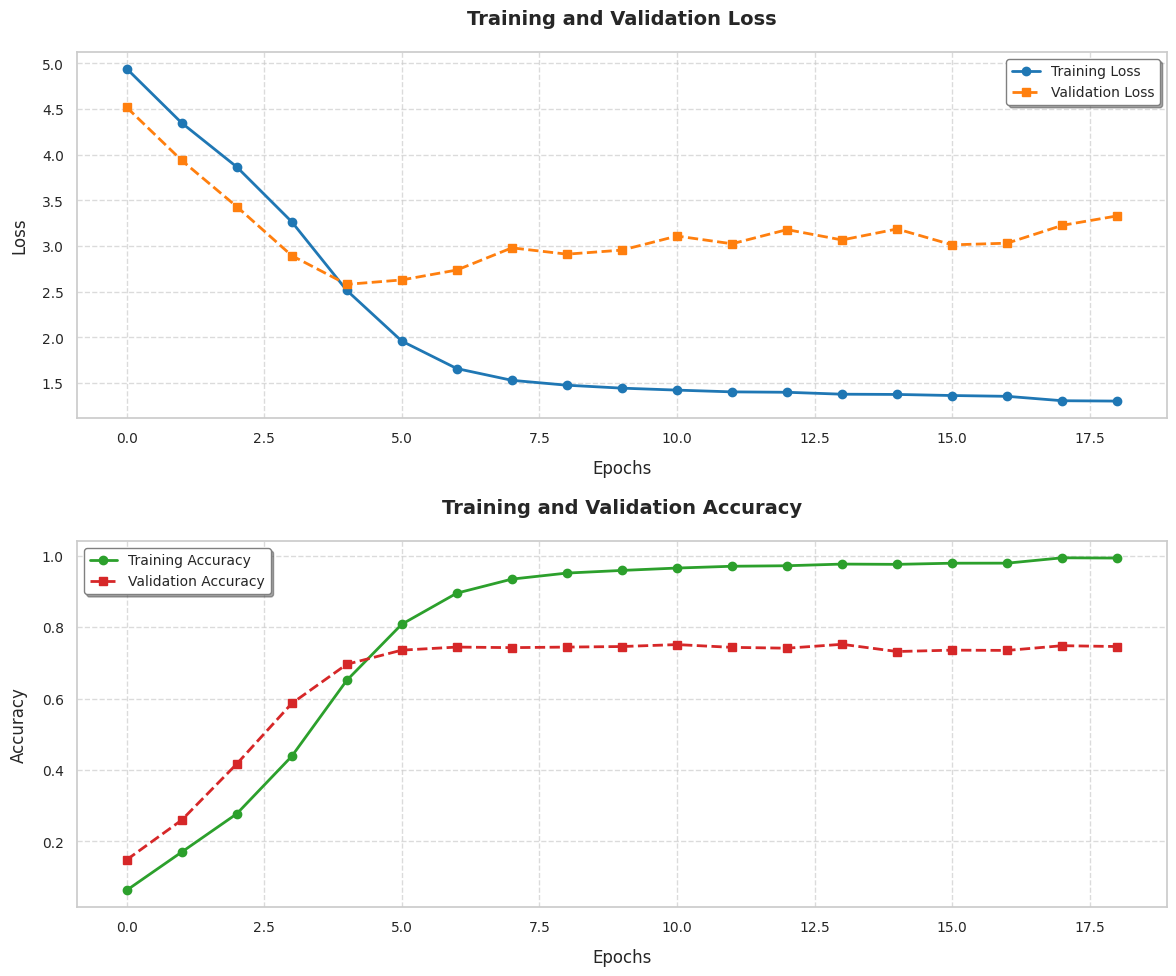

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)

history_model_VVG16 = model_VVG16.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict,
)

plot_history(history_model_VVG16)

In [ ]:
test_loss, test_accuracy = model_VVG16.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.7522 - loss: 2.8169
Test Loss: 3.04427433013916
Test Accuracy: 0.7327117323875427


In [ ]:
save_dir = '/content/drive/My Drive/SU2/models'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

model_path = os.path.join(save_dir, 'vvg16.keras')
model_VVG16.save(model_path)

history_vvg16_path = os.path.join(save_dir, 'history_model_VVG16.pkl')
with open(history_vvg16_path, "wb") as file:
    pickle.dump(history_model_VVG16.history, file)

history_vvg16_path = os.path.join(save_dir, 'history_model_VVG16.pkl')
with open(history_vvg16_path, "rb") as file:
    history_vvg16_loaded = pickle.load(file)

# **RES-NET-50**

In [ ]:
def identiti_block(X, f, filters, stage, block, kernel_init, regularizer, dropout_rate=0.0):

    conv_name_base = f"res{stage}{block}_branch"
    bn_name_base = f"bn{stage}{block}_branch"

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(1, 1), padding="valid",
               kernel_initializer=kernel_init, kernel_regularizer=regularizer,
               name=conv_name_base + "2a")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding="same",
               kernel_initializer=kernel_init, kernel_regularizer=regularizer,
               name=conv_name_base + "2b")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    if dropout_rate > 0.0:
        X = Dropout(dropout_rate)(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), padding="valid",
               kernel_initializer=kernel_init, kernel_regularizer=regularizer,
               name=conv_name_base + "2c")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2c")(X)

    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X

def conv_block(X, f, s, filters, stage, block, kernel_init, regularizer, dropout_rate=0.0):

    conv_name_base = f"res{stage}{block}_branch"
    bn_name_base = f"bn{stage}{block}_branch"

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), padding="valid",
               kernel_initializer=kernel_init, kernel_regularizer=regularizer,
               name=conv_name_base + "2a")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding="same",
               kernel_initializer=kernel_init, kernel_regularizer=regularizer,
               name=conv_name_base + "2b")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    if dropout_rate > 0.0:
        X = Dropout(dropout_rate)(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), padding="valid",
               kernel_initializer=kernel_init, kernel_regularizer=regularizer,
               name=conv_name_base + "2c")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2c")(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding="valid",
                        kernel_initializer=kernel_init, kernel_regularizer=regularizer,
                        name=conv_name_base + "1")(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + "1")(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X


def res_net_50(input_shape=(224, 224, 3),
               num_classes=37,
              learning_rate=1e-4,
               kernel_init=HeNormal(seed=0),
               l1=0.0,
               l2=0.01,
               dropout_rate=0.5):

    X_input = Input(input_shape)

    regularizer = l1_l2(l1=l1, l2=l2)

    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name="conv1", kernel_initializer=kernel_init, kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = conv_block(X, f=3, filters=[64, 64, 256], stage=2, block="a", s=1, kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [64, 64, 256], stage=2, block="b", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [64, 64, 256], stage=2, block="c", kernel_init=kernel_init, regularizer=regularizer)

    X = conv_block(X, f=3, filters=[128, 128, 512], stage=3, block="a", s=2, kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [128, 128, 512], stage=3, block="b", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [128, 128, 512], stage=3, block="c", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [128, 128, 512], stage=3, block="d", kernel_init=kernel_init, regularizer=regularizer)

    X = conv_block(X, f=3, filters=[256, 256, 1024], stage=4, block="a", s=2, kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [256, 256, 1024], stage=4, block="b", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [256, 256, 1024], stage=4, block="c", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [256, 256, 1024], stage=4, block="d", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [256, 256, 1024], stage=4, block="e", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [256, 256, 1024], stage=4, block="f", kernel_init=kernel_init, regularizer=regularizer)

    X = conv_block(X, f=3, filters=[512, 512, 2048], stage=5, block="a", s=2, kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [512, 512, 2048], stage=5, block="b", kernel_init=kernel_init, regularizer=regularizer)
    X = identiti_block(X, 3, [512, 512, 2048], stage=5, block="c", kernel_init=kernel_init, regularizer=regularizer)

    X = AveragePooling2D((2, 2), name="avg_pool")(X)

    X = Flatten()(X)
    X = Dropout(dropout_rate)(X)
    X = Dense(num_classes, activation="softmax", name=f"fc{num_classes}", kernel_initializer=GlorotUniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name="Res-Net-50")


    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):
    drop_rate = trial.suggest_float("drop_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2)
    l1 = trial.suggest_float("l1", 1e-6, 1e-2, log=True)
    l2 = trial.suggest_float("l2", 1e-5, 1e-3, log=True)

    model_cnn_simple = res_net_50(
        input_shape=(224, 224, 3),
        num_classes=37,
        dropout_rate=drop_rate,
        learning_rate=learning_rate,
        l1=l1,
        l2=l2,
    )
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)

    history = model_cnn_simple.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[early_stopping, reduce_lr,pruning_callback],
        verbose=0,
        class_weight=class_weights_dict,
    )

    return max(history.history["val_accuracy"])


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-12-14 20:52:45,710] A new study created in memory with name: no-name-5049446a-7dcf-49fb-b4d1-e2e9984ed076



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.001942575559951365.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0009712877799756825.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00048564388998784125.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00024282194499392062.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00012141097249696031.

Epoch 39: ReduceLROnPlateau reducing learning rate to 6.0705486248480156e-05.

Epoch 49: ReduceLROnPlateau reducing learning rate to 3.0352743124240078e-05.


[I 2024-12-14 21:49:27,499] Trial 0 finished with value: 0.40746501088142395 and parameters: {'drop_rate': 0.4518003062959518, 'learning_rate': 0.0038851511364454043, 'l1': 0.0006505139563614979, 'l2': 0.00026436679968796454}. Best is trial 0 with value: 0.40746501088142395.



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00047640508273616433.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00023820254136808217.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00011910127068404108.


[I 2024-12-14 22:18:47,672] Trial 1 finished with value: 0.7223950028419495 and parameters: {'drop_rate': 0.33567534400656346, 'learning_rate': 0.0009528101913533666, 'l1': 2.5425144514725475e-05, 'l2': 0.00041916727371001675}. Best is trial 1 with value: 0.7223950028419495.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.003202852327376604.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.001601426163688302.


[I 2024-12-14 22:35:59,954] Trial 2 finished with value: 0.05054432526230812 and parameters: {'drop_rate': 0.2989760183434538, 'learning_rate': 0.006405704625161556, 'l1': 0.000562039098249914, 'l2': 0.0004281610170087433}. Best is trial 1 with value: 0.7223950028419495.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0016821736935526133.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0008410868467763066.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0004205434233881533.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00021027171169407666.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00010513585584703833.


[I 2024-12-14 23:26:12,337] Trial 3 finished with value: 0.6982892751693726 and parameters: {'drop_rate': 0.15631646177648018, 'learning_rate': 0.0033643473179691586, 'l1': 3.726142614385981e-05, 'l2': 0.00020947147953311453}. Best is trial 1 with value: 0.7223950028419495.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004465107340365648.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.002232553670182824.


[I 2024-12-14 23:42:12,236] Trial 4 finished with value: 0.03888024762272835 and parameters: {'drop_rate': 0.11893222990029391, 'learning_rate': 0.008930214665163283, 'l1': 0.003609490021321092, 'l2': 2.2597280395905114e-05}. Best is trial 1 with value: 0.7223950028419495.
[I 2024-12-14 23:45:05,792] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2024-12-14 23:48:00,024] Trial 6 pruned. Trial was pruned at epoch 0.



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0025636747013777494.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0012818373506888747.


[I 2024-12-15 00:06:18,907] Trial 7 pruned. Trial was pruned at epoch 14.
[I 2024-12-15 00:11:24,902] Trial 8 pruned. Trial was pruned at epoch 2.
[I 2024-12-15 00:16:27,631] Trial 9 pruned. Trial was pruned at epoch 2.



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.1981364878010936e-05.


[I 2024-12-15 00:54:47,587] Trial 10 finished with value: 0.6181959509849548 and parameters: {'drop_rate': 0.36459366672086474, 'learning_rate': 2.3962729972805494e-05, 'l1': 2.4987034942326274e-05, 'l2': 4.287927482996462e-05}. Best is trial 1 with value: 0.7223950028419495.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005799392238259315.


[I 2024-12-15 01:13:04,405] Trial 11 pruned. Trial was pruned at epoch 14.
[I 2024-12-15 01:17:02,337] Trial 12 pruned. Trial was pruned at epoch 1.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0008687948575243354.


[I 2024-12-15 01:35:24,844] Trial 13 pruned. Trial was pruned at epoch 14.



Epoch 17: ReduceLROnPlateau reducing learning rate to 3.22788255289197e-05.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.613941276445985e-05.

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.069706382229924e-06.


[I 2024-12-15 02:10:20,806] Trial 14 finished with value: 0.635303258895874 and parameters: {'drop_rate': 0.36294077660913254, 'learning_rate': 6.455765232506194e-05, 'l1': 8.658451626635916e-06, 'l2': 1.0974550252636934e-05}. Best is trial 1 with value: 0.7223950028419495.
[I 2024-12-15 02:15:23,631] Trial 15 pruned. Trial was pruned at epoch 2.
[I 2024-12-15 02:20:32,407] Trial 16 pruned. Trial was pruned at epoch 2.
[I 2024-12-15 02:23:23,732] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2024-12-15 02:26:15,955] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2024-12-15 02:29:14,459] Trial 19 pruned. Trial was pruned at epoch 0.
[I 2024-12-15 02:33:11,133] Trial 20 pruned. Trial was pruned at epoch 1.



Epoch 18: ReduceLROnPlateau reducing learning rate to 3.9118942368077114e-05.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.9559471184038557e-05.


[I 2024-12-15 03:02:42,592] Trial 21 finished with value: 0.6446345448493958 and parameters: {'drop_rate': 0.3392431087746925, 'learning_rate': 7.823788686737814e-05, 'l1': 8.081728343221222e-06, 'l2': 1.0413204539577106e-05}. Best is trial 1 with value: 0.7223950028419495.



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0004347176000010222.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002173588000005111.


[I 2024-12-15 03:28:54,043] Trial 22 finished with value: 0.7068428993225098 and parameters: {'drop_rate': 0.32896223631428884, 'learning_rate': 0.0008694351745048821, 'l1': 1.4541128502999462e-05, 'l2': 1.2585539776562976e-05}. Best is trial 1 with value: 0.7223950028419495.
[I 2024-12-15 03:31:45,991] Trial 23 pruned. Trial was pruned at epoch 0.
[I 2024-12-15 03:38:04,191] Trial 24 pruned. Trial was pruned at epoch 3.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00042132241651415825.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00021066120825707912.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00010533060412853956.


[I 2024-12-15 04:04:04,250] Trial 25 finished with value: 0.7099533677101135 and parameters: {'drop_rate': 0.40281209792486394, 'learning_rate': 0.0008426448259803217, 'l1': 4.083663260008805e-06, 'l2': 0.00010832656157977405}. Best is trial 1 with value: 0.7223950028419495.



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00034308963222429156.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00017154481611214578.

Epoch 23: ReduceLROnPlateau reducing learning rate to 8.577240805607289e-05.


[I 2024-12-15 04:33:26,496] Trial 26 finished with value: 0.7255054712295532 and parameters: {'drop_rate': 0.39279496100530775, 'learning_rate': 0.0006861792404594372, 'l1': 2.657174317282755e-06, 'l2': 0.00010873941053216025}. Best is trial 26 with value: 0.7255054712295532.
[I 2024-12-15 04:51:49,853] Trial 27 pruned. Trial was pruned at epoch 14.
[I 2024-12-15 04:56:54,891] Trial 28 pruned. Trial was pruned at epoch 2.
[I 2024-12-15 05:01:01,127] Trial 29 pruned. Trial was pruned at epoch 1.
[I 2024-12-15 05:05:01,391] Trial 30 pruned. Trial was pruned at epoch 1.


In [ ]:
model_res_net_50 = res_net_50(
        input_shape=(224, 224, 3),
        num_classes=37,
        dropout_rate=0.39279496100530775,
        learning_rate=0.0006861792404594372,
        kernel_init=HeNormal(seed=0),
        l1=2.657174317282755e-06,
        l2=0.00010873941053216025
    )
model_res_net_50.summary()


Model: "Res-Net-50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 64)   │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 112, 112, 64)   │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 55, 55, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 55, 55, 64)     │          4,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 55, 55, 64)     │            256 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2a[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 55, 55, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 55, 55, 64)     │            256 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2b[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 55, 55, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 55, 55, 256)    │         16,640 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 55, 55, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch1              │ (None, 55, 55, 256)    │          1,024 │ res2a_branch1[0][0]    │
│ (BatchNormalization) 

 Total params: 24,269,733 (92.58 MB)

 Trainable params: 24,216,613 (92.38 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 223s 210ms/step - accuracy: 0.0725 - loss: 13.0342 - val_accuracy: 0.2378 - val_loss: 9.1317 - learning_rate: 6.8618e-04
Epoch 2/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.2126 - loss: 8.6346 - val_accuracy: 0.2603 - val_loss: 7.1490 - learning_rate: 6.8618e-04
Epoch 3/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.3182 - loss: 6.5013 - val_accuracy: 0.3675 - val_loss: 5.5342 - learning_rate: 6.8618e-04
Epoch 4/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.4242 - loss: 4.9984 - val_accuracy: 0.4040 - val_loss: 4.6389 - learning_rate: 6.8618e-04
Epoch 5/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.5192 - loss: 4.0003 - val_accuracy: 0.4281 - val_loss: 4.3873 - learning_rate: 6.8618e-04
Epoch 6/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.6032 - loss: 3.3768 - val_accuracy: 0.5657 - val_loss: 3.6428 - learning_rate: 6.8618e-04
Epoch 7/500
747/747 ━━━━━━━━━━━━━

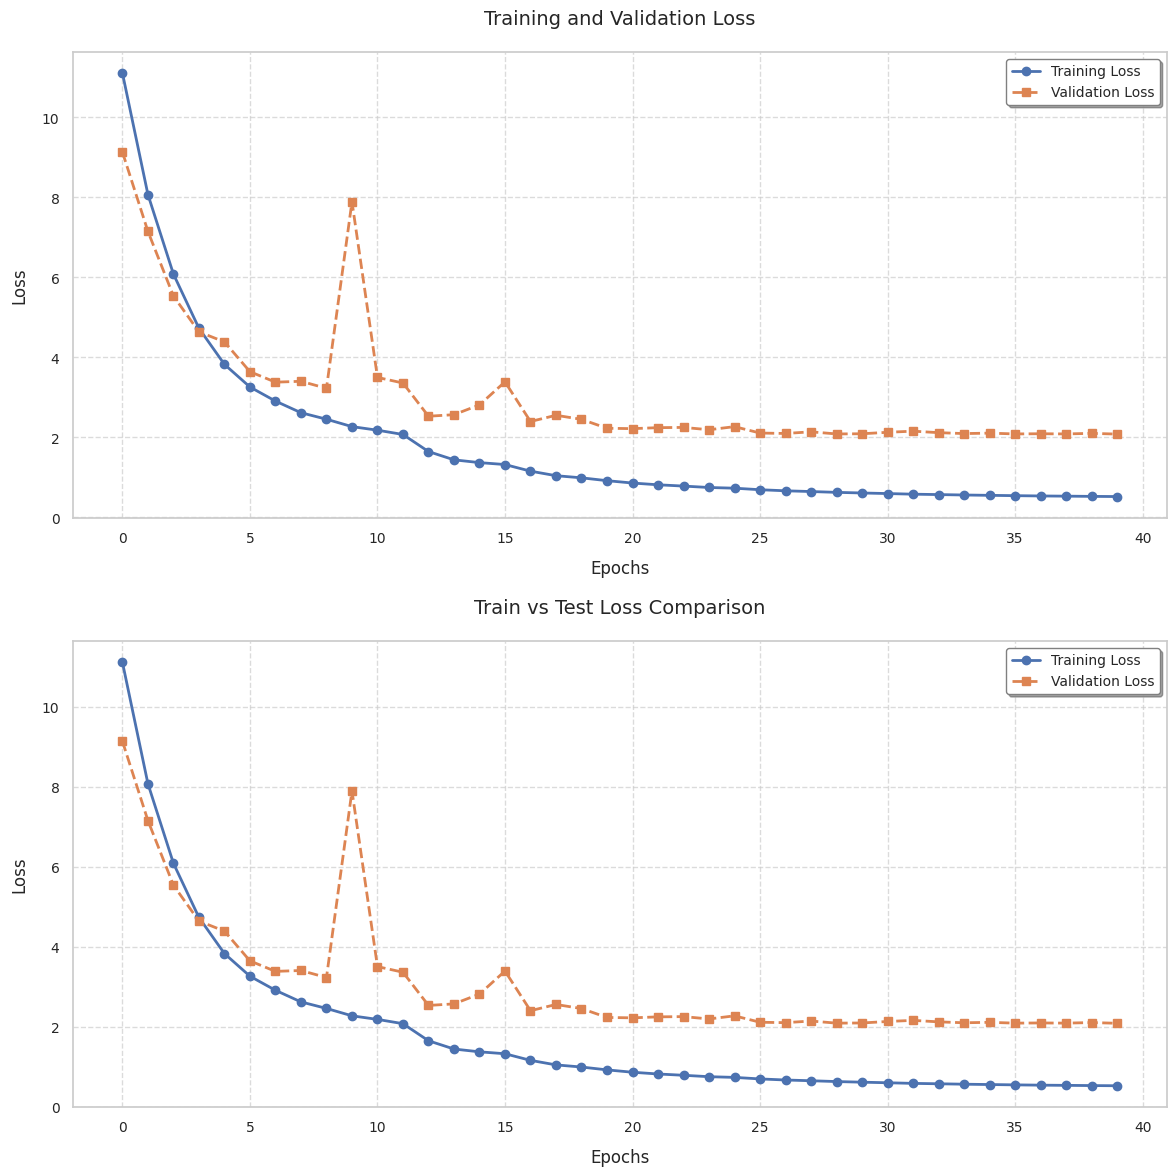

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)

history_model_res_net = model_res_net_50.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict,
)


plot_history(history_model_res_net)

In [ ]:
test_loss, test_accuracy = model_res_net_50.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8033 - loss: 2.0788
Test Loss: 2.0910797119140625
Test Accuracy: 0.8034188151359558


In [ ]:

save_dir = '/content/drive/My Drive/SU2/models'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'res_net_50.keras')
model_res_net_50.save(model_path)
print(f"Model saved to: {model_path}")

history_path = os.path.join(save_dir, 'history_model_res_net.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history_model_res_net.history, file)

history_path = os.path.join(save_dir, 'history_model_res_net.pkl')
with open(history_path, "rb") as file:
    history_res_net_loaded = pickle.load(file)


Model saved to: /content/drive/My Drive/SU2/models/res_net_50.keras


# **EFFICENT NET **

efficent net

In [ ]:
def squeeze_and_excite(input_tensor, filters, ratio=16):
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

def mb_conv_block(input_tensor, filters, kernel_size, strides, expansion_factor, se_ratio, drop_rate, kernel_initializer, regularizer):
    expanded_filters = input_tensor.shape[-1] * expansion_factor

    x = Conv2D(
        expanded_filters,
        1,
        padding='same',
        use_bias=False,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=regularizer
    )(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding='same',
        use_bias=False
    )(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    if se_ratio:
        x = squeeze_and_excite(x, expanded_filters, ratio=se_ratio)


    x = Conv2D(
        filters,
        1,
        padding='same',
        use_bias=False,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=regularizer
    )(x)
    x = BatchNormalization()(x)


    if strides == 1 and input_tensor.shape[-1] == filters:
        x = Add()([x, input_tensor])

    return x


def build_efficientnet(input_shape=(224, 224, 3), num_classes=37, drop_rate=0.2, learning_rate=1e-4  , kernel_initializer="he_normal", l1=0.0, l2=1e-4):
    regularizer = l1_l2(l1=l1, l2=l2)
    input_layer = Input(shape=input_shape)


    x = Conv2D(
        32,
        3,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=regularizer
    )(input_layer)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = mb_conv_block(x, filters=16, kernel_size=3, strides=1, expansion_factor=1, se_ratio=4, drop_rate=drop_rate, kernel_initializer=kernel_initializer, regularizer=regularizer)
    x = mb_conv_block(x, filters=24, kernel_size=3, strides=2, expansion_factor=6, se_ratio=4, drop_rate=drop_rate, kernel_initializer=kernel_initializer, regularizer=regularizer)
    x = mb_conv_block(x, filters=40, kernel_size=5, strides=2, expansion_factor=6, se_ratio=4, drop_rate=drop_rate, kernel_initializer=kernel_initializer, regularizer=regularizer)
    x = mb_conv_block(x, filters=80, kernel_size=3, strides=2, expansion_factor=6, se_ratio=4, drop_rate=drop_rate, kernel_initializer=kernel_initializer, regularizer=regularizer)
    x = mb_conv_block(x, filters=112, kernel_size=5, strides=1, expansion_factor=6, se_ratio=4, drop_rate=drop_rate, kernel_initializer=kernel_initializer, regularizer=regularizer)
    x = mb_conv_block(x, filters=192, kernel_size=5, strides=2, expansion_factor=6, se_ratio=4, drop_rate=drop_rate, kernel_initializer=kernel_initializer, regularizer=regularizer)
    x = mb_conv_block(x, filters=320, kernel_size=3, strides=1, expansion_factor=6, se_ratio=4, drop_rate=drop_rate, kernel_initializer=kernel_initializer, regularizer=regularizer)


    x = GlobalAveragePooling2D()(x)
    x = Dropout(drop_rate)(x)
    output_layer = Dense(
        num_classes,
        activation='softmax',
        kernel_initializer=GlorotUniform(),
        kernel_regularizer=regularizer
    )(x)

    model = Model(inputs=input_layer, outputs=output_layer)


    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

    return model



In [ ]:
model_efficientnet = build_efficientnet(
    input_shape=(224, 224, 3),
    num_classes=37,
    drop_rate=0.5,
    learning_rate=0.002228513093292559,
    kernel_initializer=HeNormal(seed=0),
    l1=1.6003794920007946e-06,
    l2=2.1414210010958212e-04
)

model_efficientnet.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 32)   │            128 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_49             │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 112, 112, 32)   │          1,024 │ activation_49[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 32)   │            128 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_50             │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 112, 112, 32)   │            288 │ activation_50[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_51             │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ activation_51[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 8)              │            264 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │            288 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 112, 112, 32)   │              0 │ activation_51[0][0],   │
│                      

 Total params: 2,066,629 (7.88 MB)

 Trainable params: 2,053,733 (7.83 MB)

 Non-trainable params: 12,896 (50.38 KB)

Epoch 1/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 171s 147ms/step - accuracy: 0.0886 - loss: 4.7341 - val_accuracy: 0.1462 - val_loss: 3.8364 - learning_rate: 0.0022
Epoch 2/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.2242 - loss: 3.2469 - val_accuracy: 0.0933 - val_loss: 4.3261 - learning_rate: 0.0022
Epoch 3/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.3321 - loss: 2.8412 - val_accuracy: 0.2753 - val_loss: 3.1659 - learning_rate: 0.0022
Epoch 4/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.4249 - loss: 2.5858 - val_accuracy: 0.4051 - val_loss: 2.7661 - learning_rate: 0.0022
Epoch 5/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.4852 - loss: 2.4257 - val_accuracy: 0.4393 - val_loss: 2.6797 - learning_rate: 0.0022
Epoch 6/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.5431 - loss: 2.2925 - val_accuracy: 0.4806 - val_loss: 2.5146 - learning_rate: 0.0022
Epoch 7/500
747/747 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0

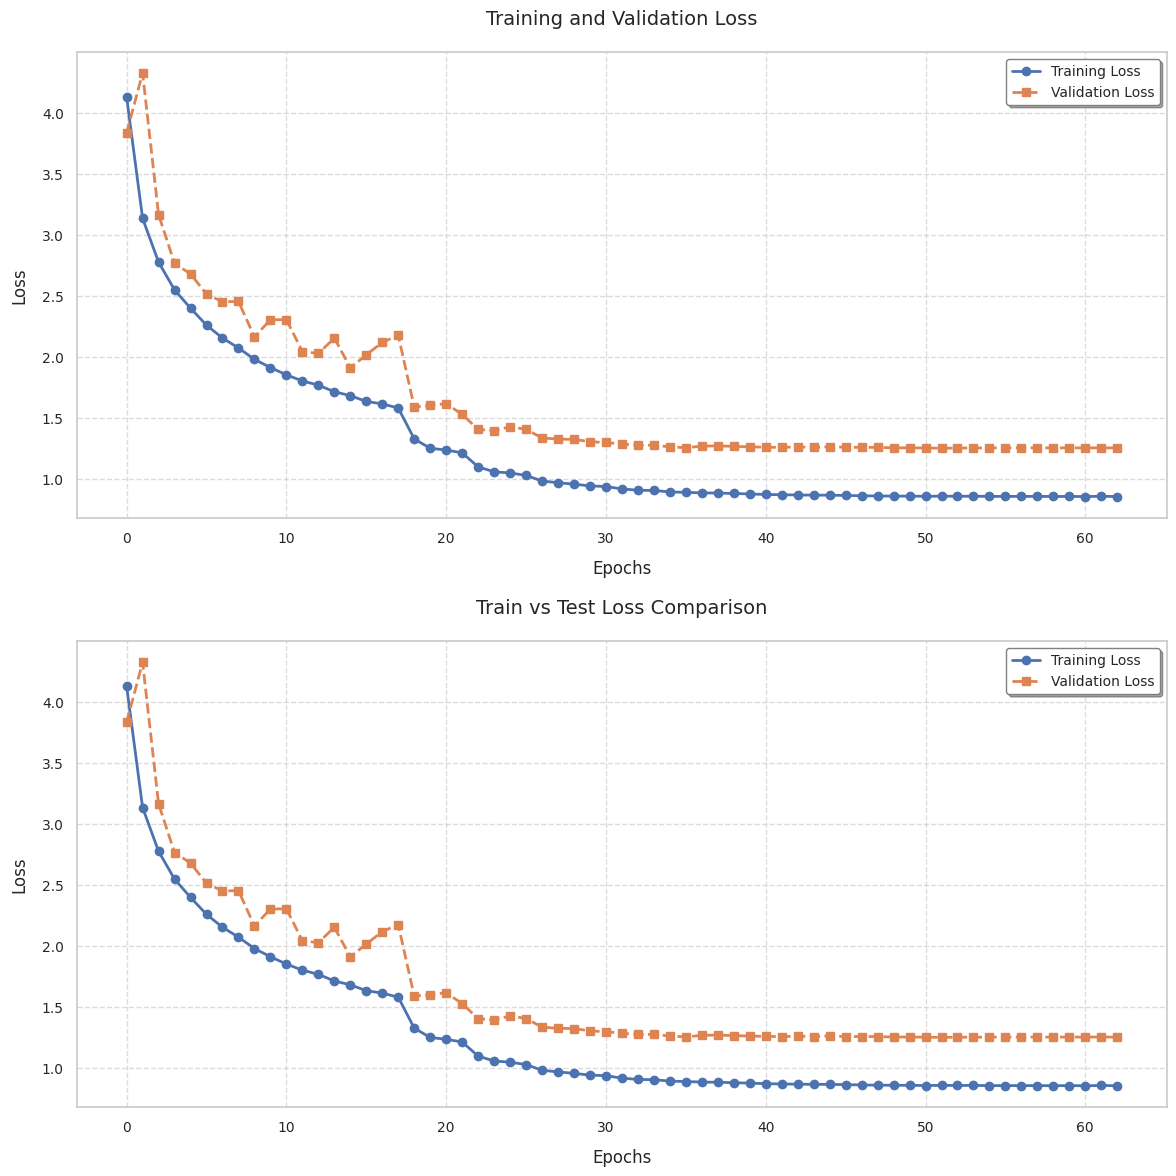

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)


history_model_efficientnet = model_efficientnet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict,
)


plot_history(history_model_efficientnet)


In [ ]:
test_loss, test_accuracy = model_efficientnet.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 386ms/step - accuracy: 0.8647 - loss: 1.2522
Test Loss: 1.2261624336242676
Test Accuracy: 0.8725718855857849


In [ ]:

save_dir = '/content/drive/My Drive/SU2/models'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'efficient_net.keras')
model_efficientnet.save(model_path)

history_path_model_efficientnet = os.path.join(save_dir, 'history_model_efficientnet.pkl')
with open(history_path_model_efficientnet, "wb") as file:
    pickle.dump(history_model_efficientnet.history, file)

history_path_model_efficientnet = os.path.join(save_dir, 'history_model_efficientnet.pkl')

with open(history_path_model_efficientnet, "rb") as file:
    history_efficientnet_loaded = pickle.load(file)


# **EVALVACIJA**

In [ ]:
import pickle
save_dir = '/content/drive/My Drive/SU2/models'


history_files = {
    "le_net_5": os.path.join(save_dir, 'history_model_lenet5.pkl'),
    "cnn_simple_1": os.path.join(save_dir, 'history_model_cnn_simple_1.pkl'),
    "cnn_simple_2": os.path.join(save_dir, 'history_model_cnn_simple_2.pkl'),
    "alexnet": os.path.join(save_dir, 'history_alex_net.pkl'),
    "vgg16": os.path.join(save_dir, 'history_model_VVG16.pkl'),
    "resnet": os.path.join(save_dir, 'history_model_res_net.pkl'),
    "efficientnet": os.path.join(save_dir, 'history_model_efficientnet.pkl'),
}

loaded_histories = {}

for model_name, file_path in history_files.items():
    try:
        with open(file_path, "rb") as file:
            loaded_histories[model_name] = pickle.load(file)
        print(f"History for {model_name} loaded successfully.")
    except Exception as e:
        print(f"Failed to load history for {model_name}: {e}")


History for le_net_5 loaded successfully.
History for cnn_simple_1 loaded successfully.
History for cnn_simple_2 loaded successfully.
History for alexnet loaded successfully.
History for vgg16 loaded successfully.
History for resnet loaded successfully.
History for efficientnet loaded successfully.


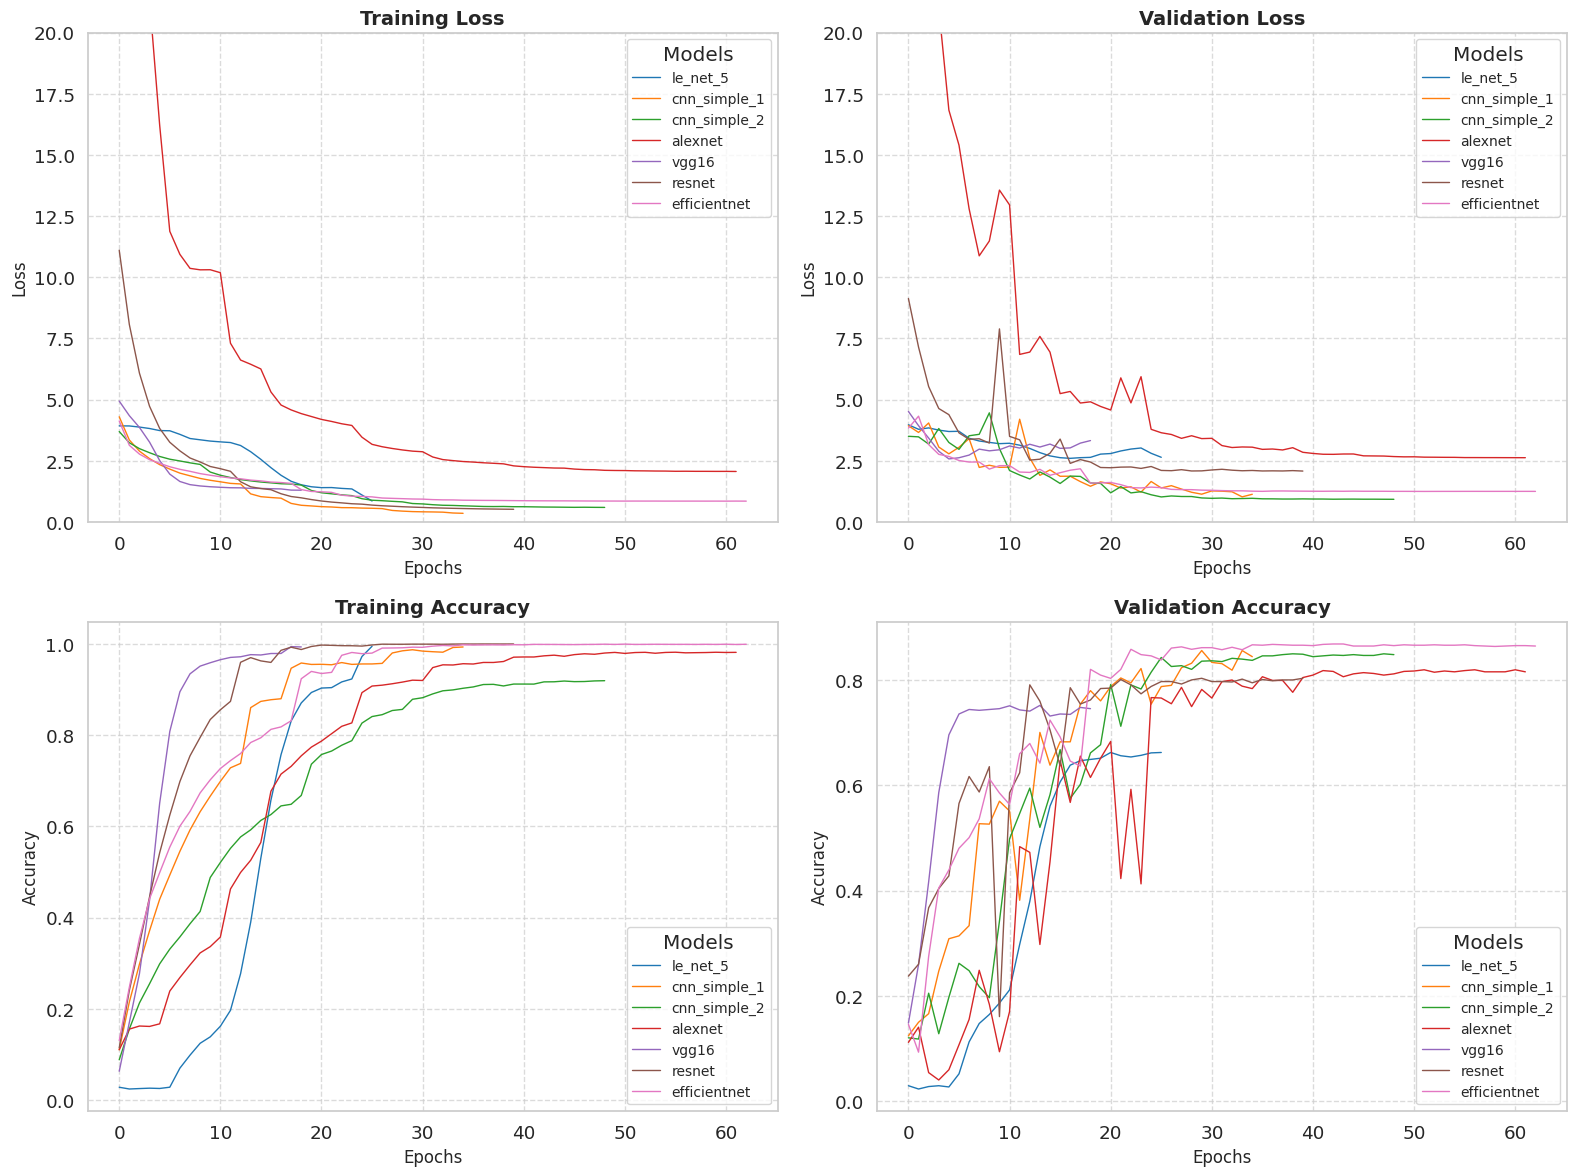

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

def plot_all_metrics_together(histories):
    metrics = ["loss", "val_loss", "accuracy", "val_accuracy"]
    titles = ["Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"]
    ylabels = ["Loss", "Loss", "Accuracy", "Accuracy"]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for ax, metric, title, ylabel in zip(axes, metrics, titles, ylabels):
        for name, history in histories.items():
            if metric in history:
                ax.plot(history[metric], label=f"{name}", linewidth=1)
        ax.set_title(title, fontweight='bold', fontsize=14)
        ax.set_xlabel("Epochs", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)

        if metric in ["loss", "val_loss"]:
            ax.set_ylim(0, 20)
        ax.legend(loc="best", fontsize=10, title="Models")
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Plot all metrics together
plot_all_metrics_together(loaded_histories)


In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

save_dir = '/content/drive/My Drive/SU2/models'

model_paths = {
    "Le-net-5": os.path.join(save_dir, 'model_lenet5.keras'),
    "CNN Simple 1": os.path.join(save_dir, 'model_cnn_simple_1.keras'),
    "CNN Simple 2": os.path.join(save_dir, 'model_cnn_simple_2.keras'),
    "VVG-16": os.path.join(save_dir, 'vvg16.keras'),
    "AlexNet": os.path.join(save_dir, 'alex_net.keras'),
    "ResNet-50": os.path.join(save_dir, 'res_net_50.keras'),
    "EfficientNet": os.path.join(save_dir, 'efficiant_net.keras')
}

results = {}
classification_reports = {}

for model_name, model_path in model_paths.items():
    try:
        model = load_model(model_path)

        y_true = []
        for _, label_batch in test_dataset:
            y_true.extend(np.argmax(label_batch, axis=1))
        y_true = np.array(y_true)

        label_names = test_dataset_orig.class_names

        y_pred = model.predict(test_dataset, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        loss, accuracy = model.evaluate(test_dataset, verbose=0)
        num_params = model.count_params()
        aic = 2 * num_params + 2 * loss

        precision = precision_score(y_true, y_pred_classes, average='weighted')
        recall = recall_score(y_true, y_pred_classes, average='weighted')
        f1 = f1_score(y_true, y_pred_classes, average='weighted')

        results[model_name] = {
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "num_params": num_params,
            "aic": aic
        }

        classification_reports[model_name] = classification_report(
            y_true, y_pred_classes, target_names=label_names, output_dict=True
        )

        print(f"{model_name}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AIC = {aic:.2f}")

    except Exception as e:
        print(f"Failed to process {model_name}: {e}")

Le-net-5: Loss = 2.9495, Accuracy = 0.6325, Precision = 0.6537, Recall = 0.6325, F1-Score = 0.6367, AIC = 22207759.90
CNN Simple 1: Loss = 1.2279, Accuracy = 0.8446, Precision = 0.8569, Recall = 0.8446, F1-Score = 0.8455, AIC = 941836.46
CNN Simple 2: Loss = 0.9336, Accuracy = 0.8407, Precision = 0.8467, Recall = 0.8407, F1-Score = 0.8406, AIC = 496171.87
VVG-16: Loss = 3.2249, Accuracy = 0.7211, Precision = 0.7384, Recall = 0.7211, F1-Score = 0.7231, AIC = 268824272.45
AlexNet: Loss = 2.7022, Accuracy = 0.8026, Precision = 0.8095, Recall = 0.8026, F1-Score = 0.8027, AIC = 53835343.40
ResNet-50: Loss = 2.0726, Accuracy = 0.8112, Precision = 0.8164, Recall = 0.8112, F1-Score = 0.8112, AIC = 48539470.15
EfficientNet: Loss = 1.4941, Accuracy = 0.8205, Precision = 0.8288, Recall = 0.8205, F1-Score = 0.8208, AIC = 4133260.99


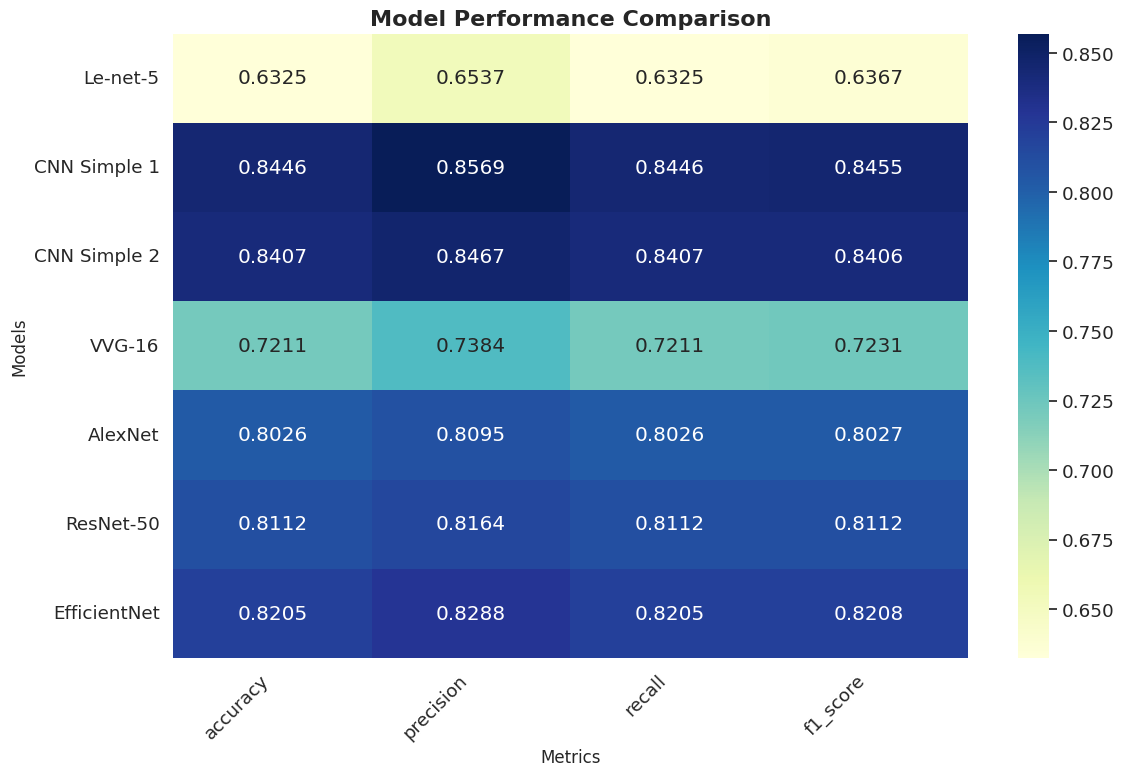

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

df = pd.DataFrame(results).T

metrics_without_aic = ['accuracy', 'precision', 'recall', 'f1_score']

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[metrics_without_aic], annot=True, fmt='.4f', cmap='YlGnBu', ax=ax)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


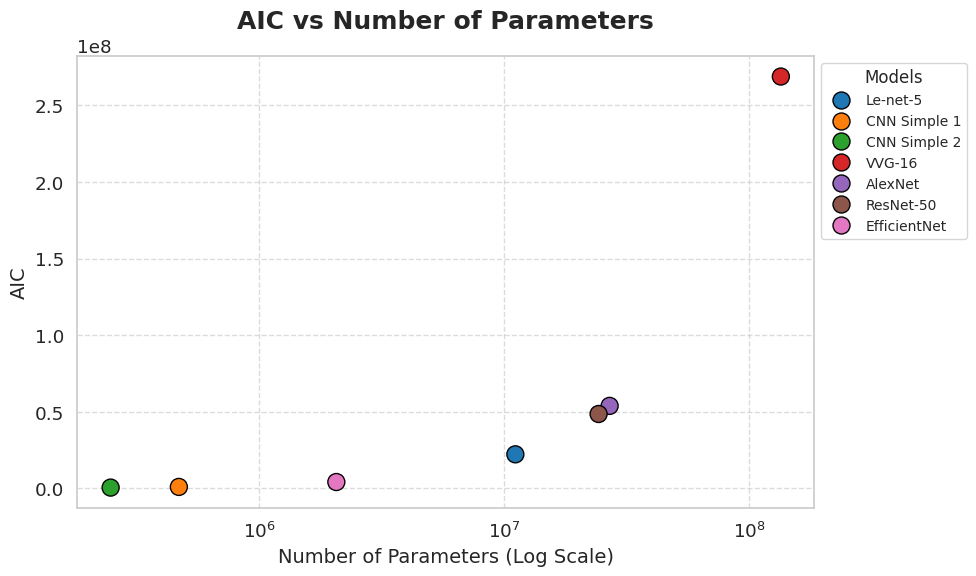

In [ ]:
if 'num_params' in df.columns and 'aic' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x='num_params',
        y='aic',
        hue=df.index,
        palette='tab10',
        s=150,
        edgecolor='black'
    )
    plt.title('AIC vs Number of Parameters', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of Parameters (Log Scale)', fontsize=14)
    plt.ylabel('AIC', fontsize=14)
    plt.xscale('log')
    plt.legend(
        title='Models',
        fontsize=10,
        title_fontsize=12,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'num_params' and 'aic' are missing in the data.")

TEST NA RANDOM SLIKAH IZ INTERNET

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


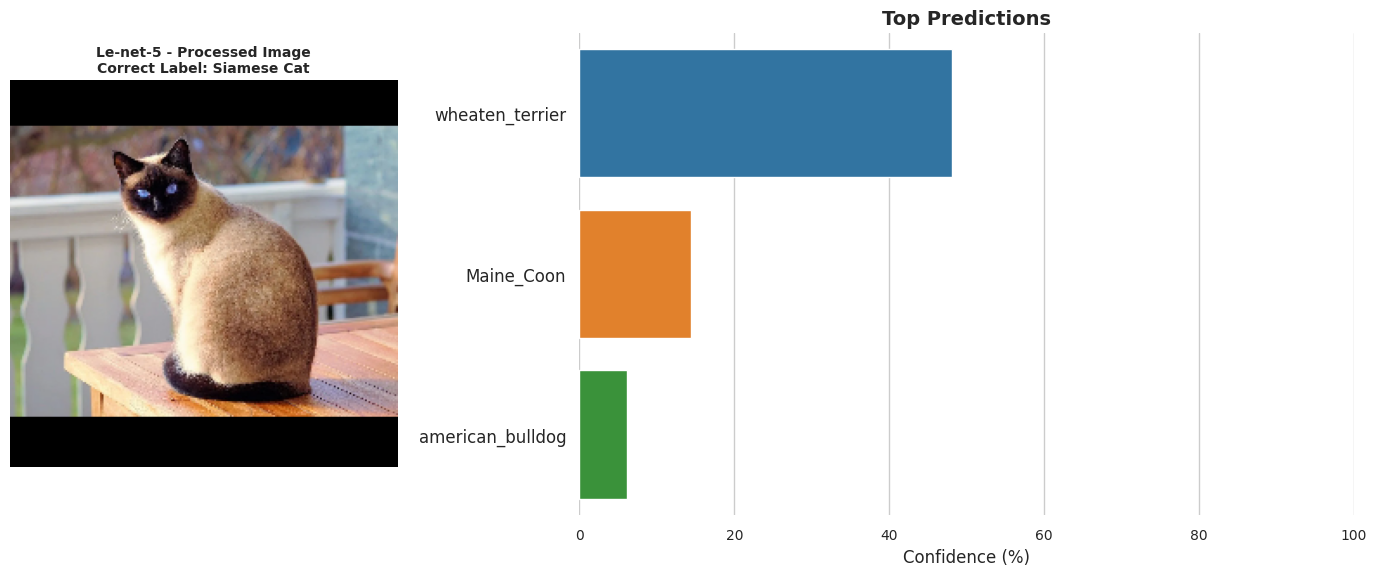

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


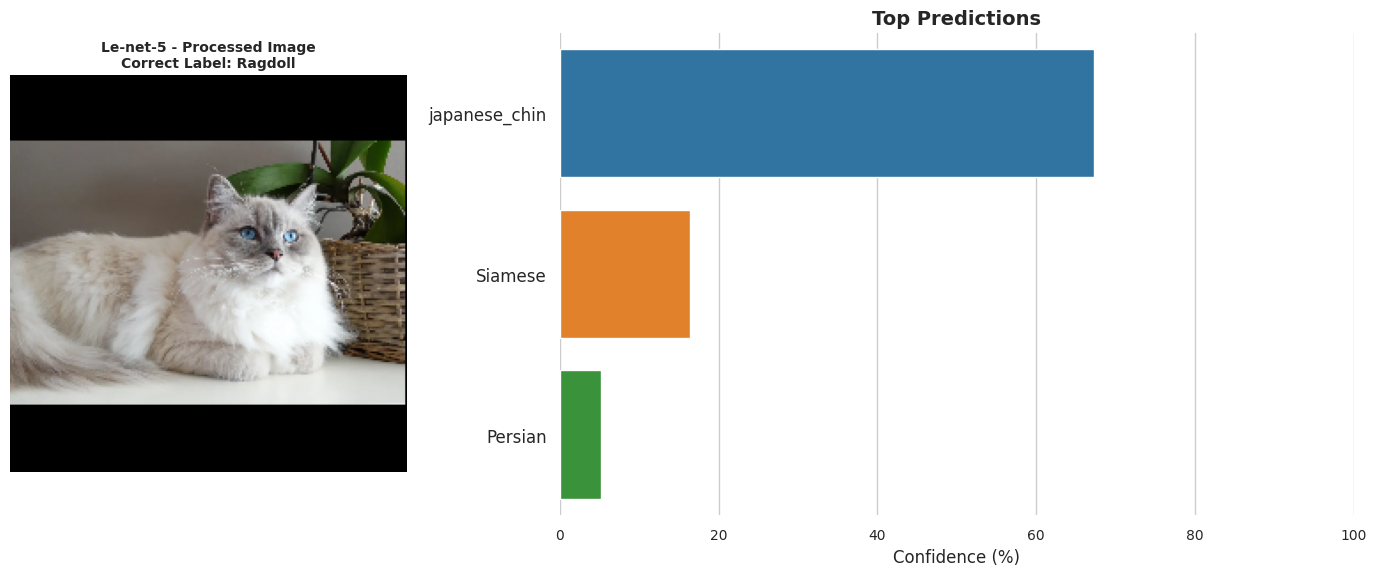

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


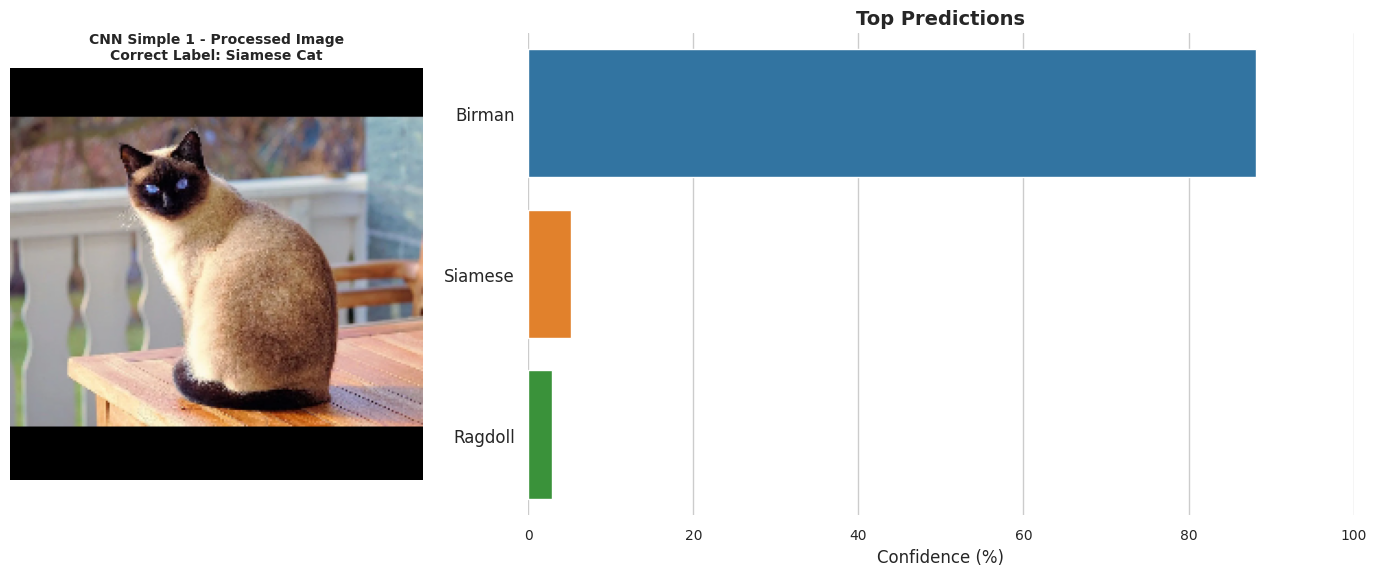

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


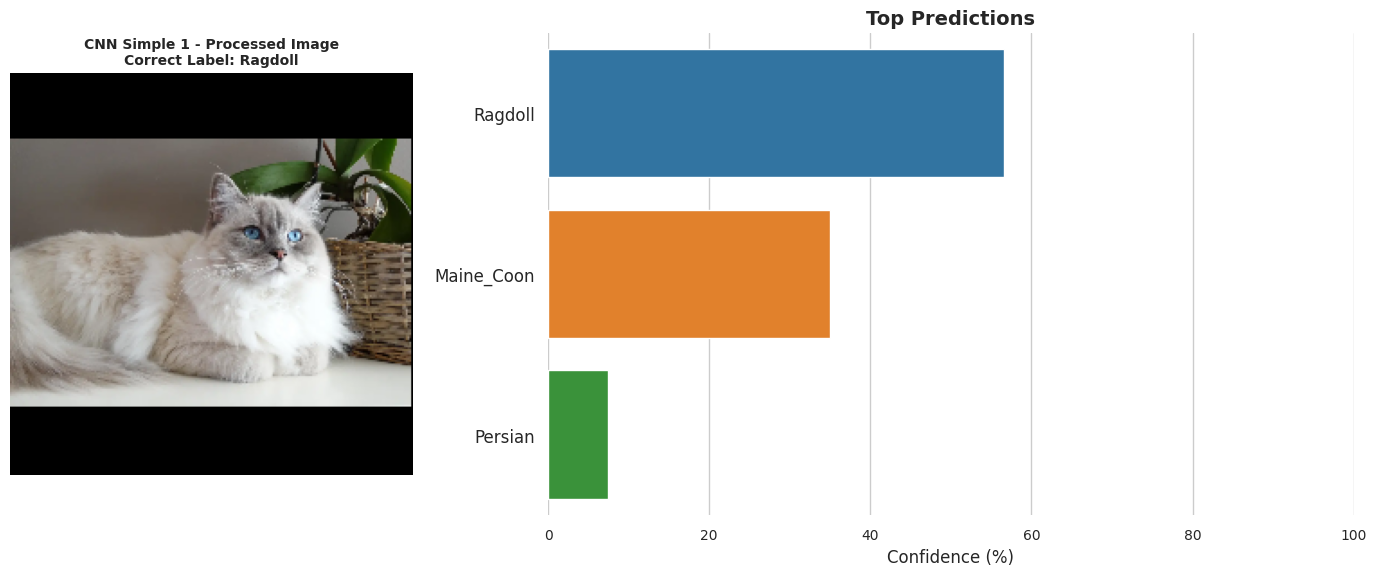

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


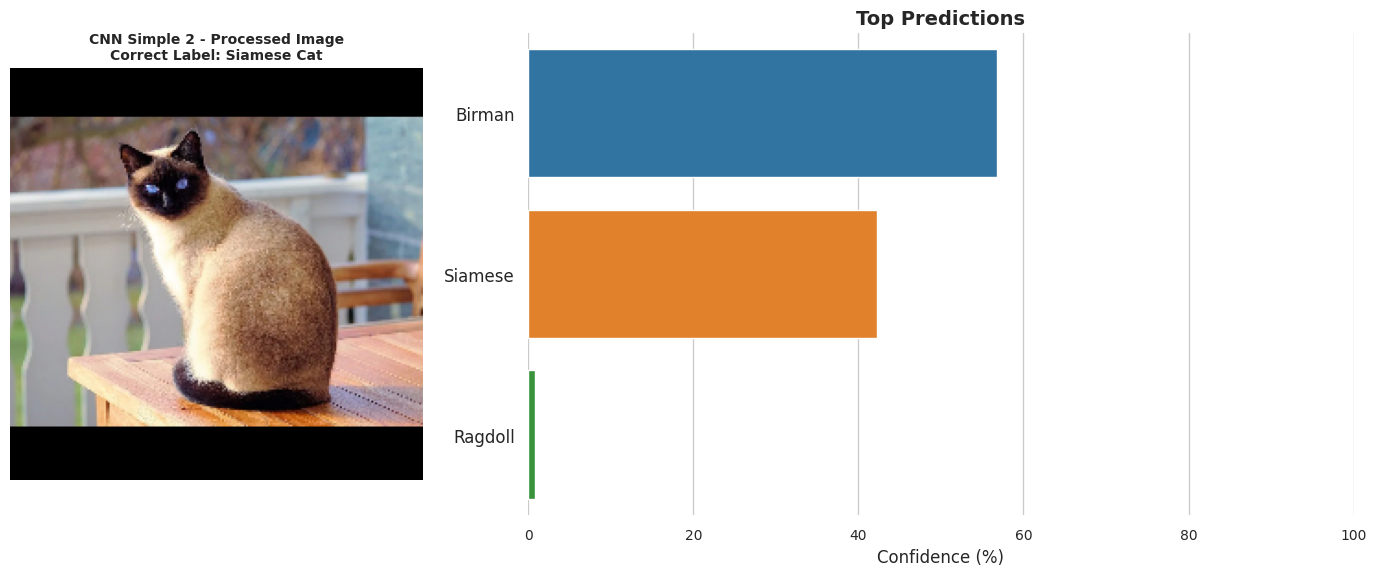

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


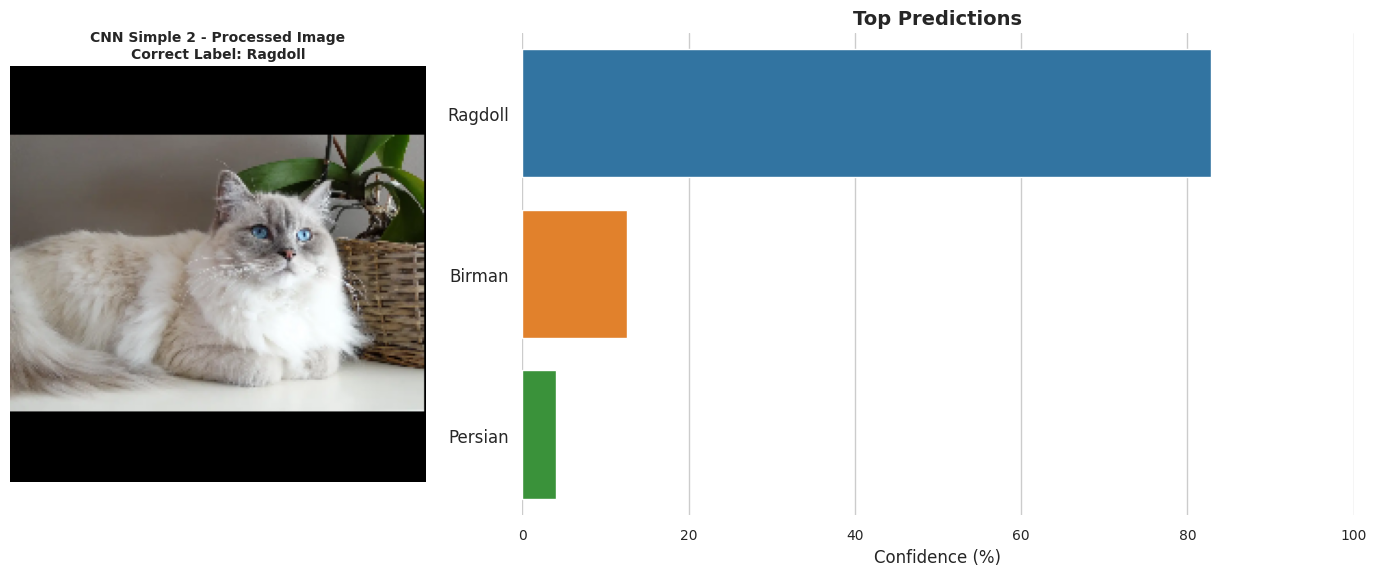

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


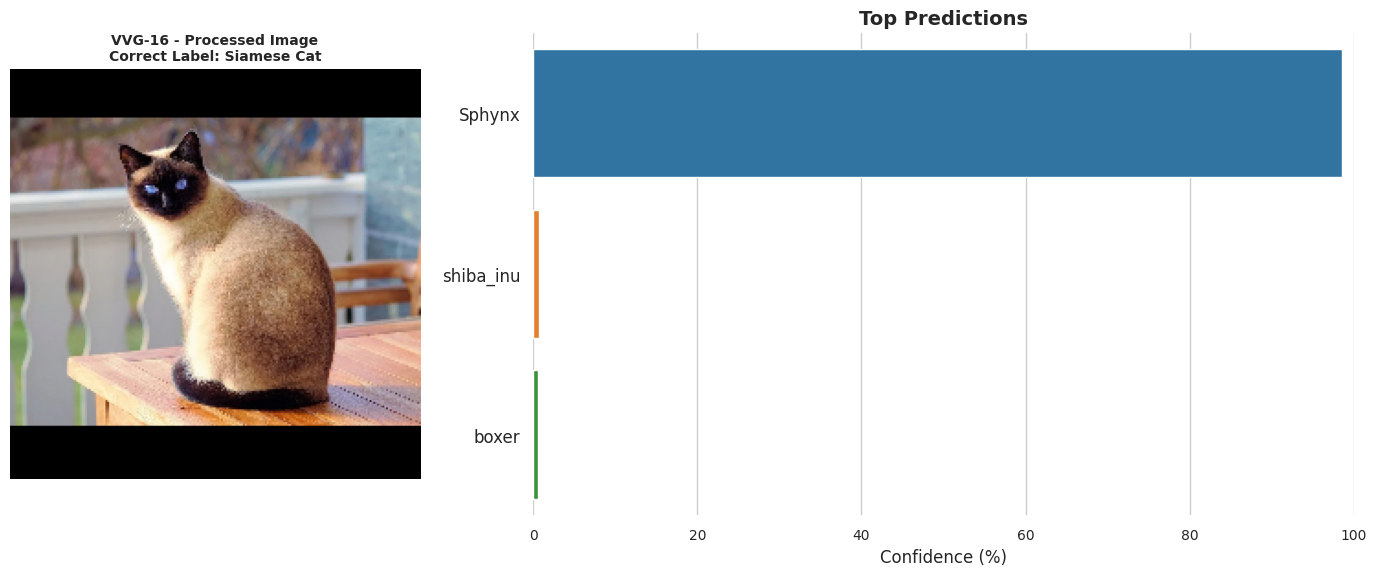

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


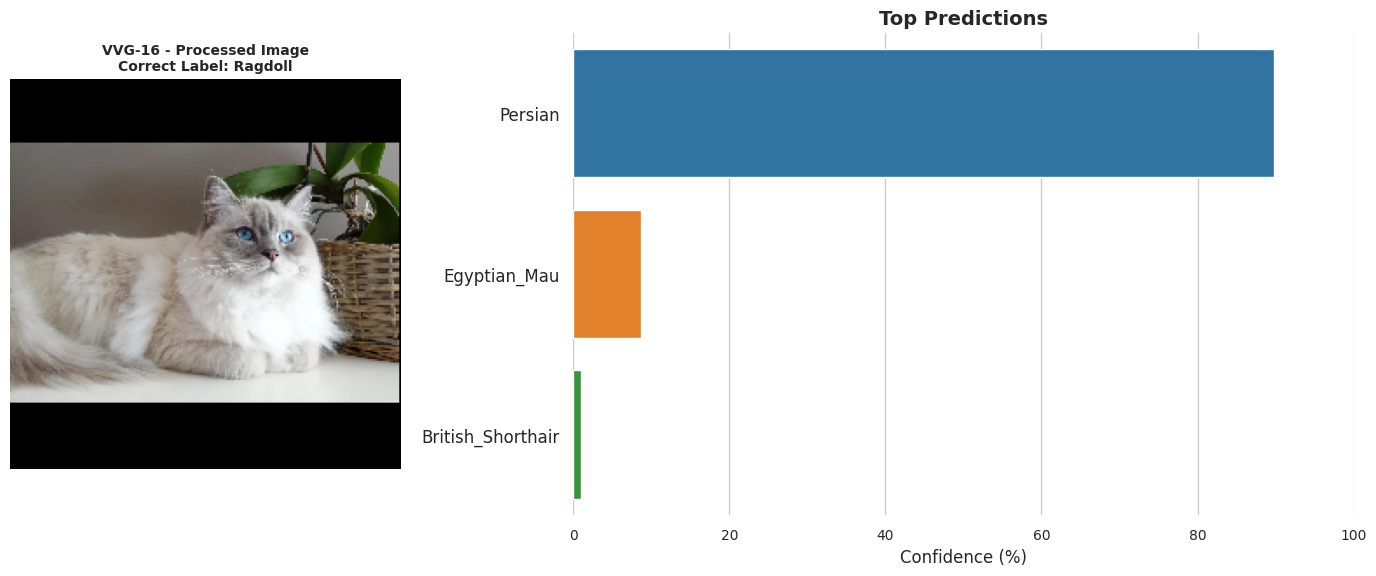

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


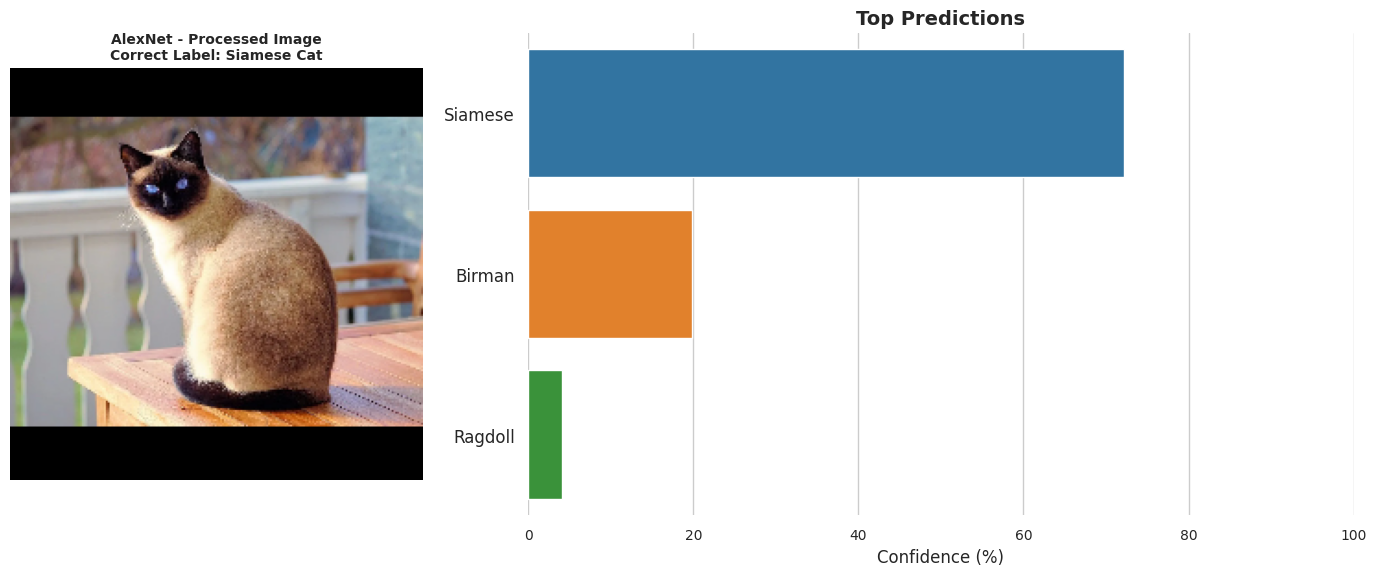

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


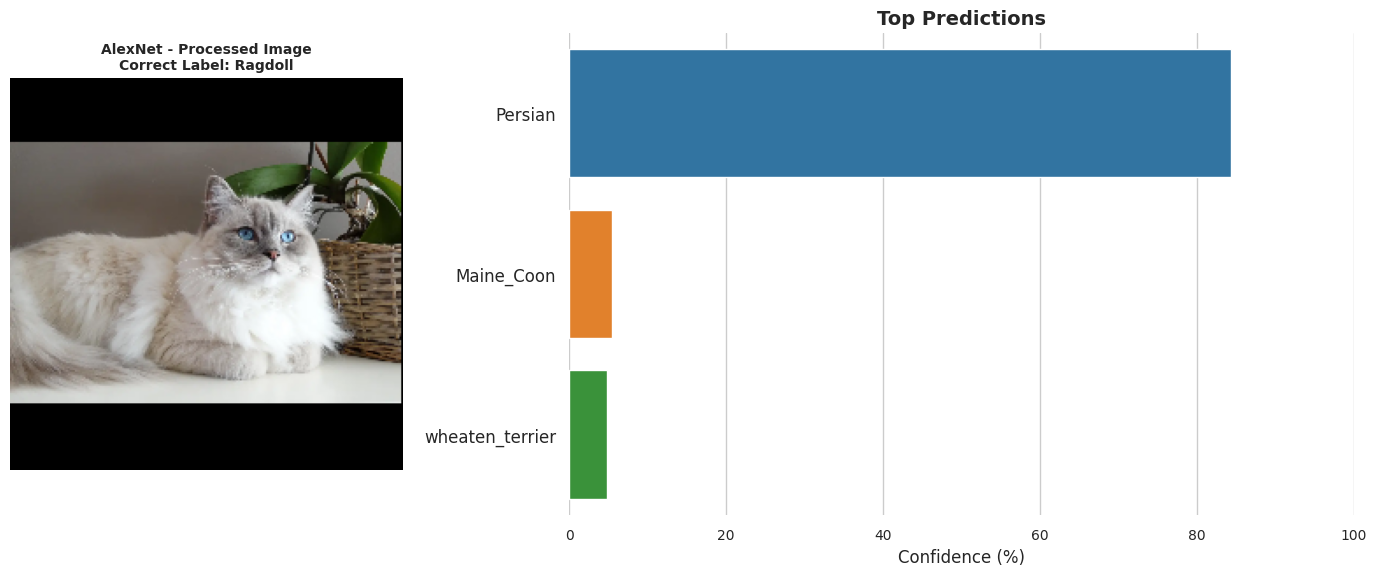

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


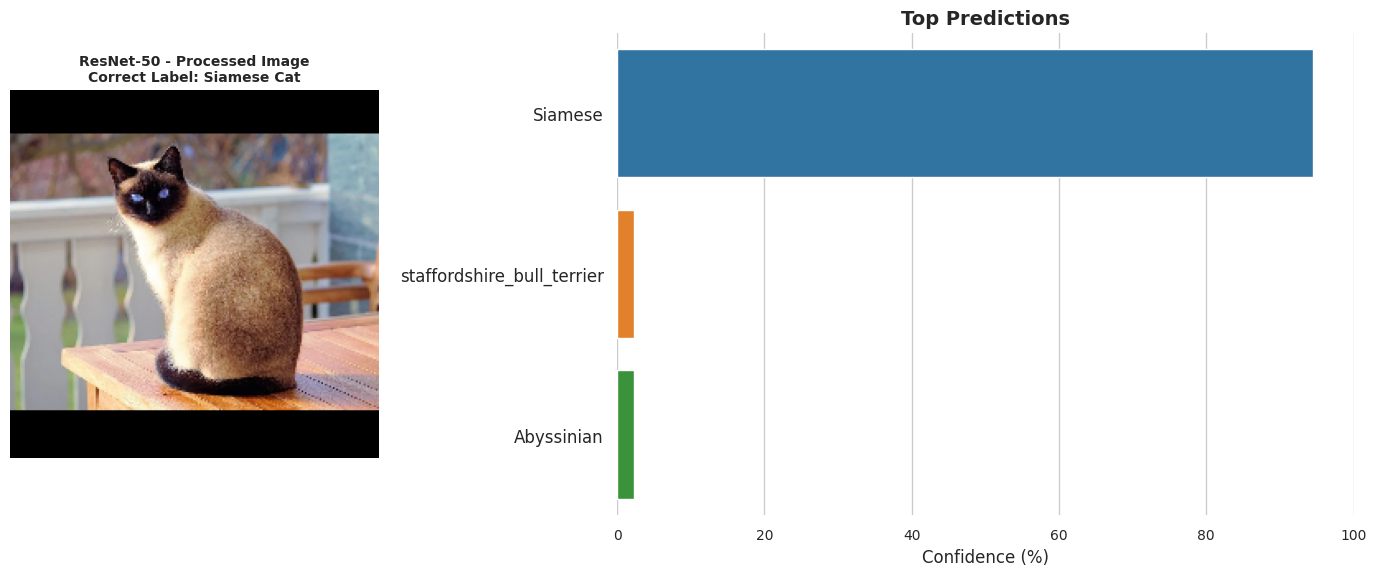

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


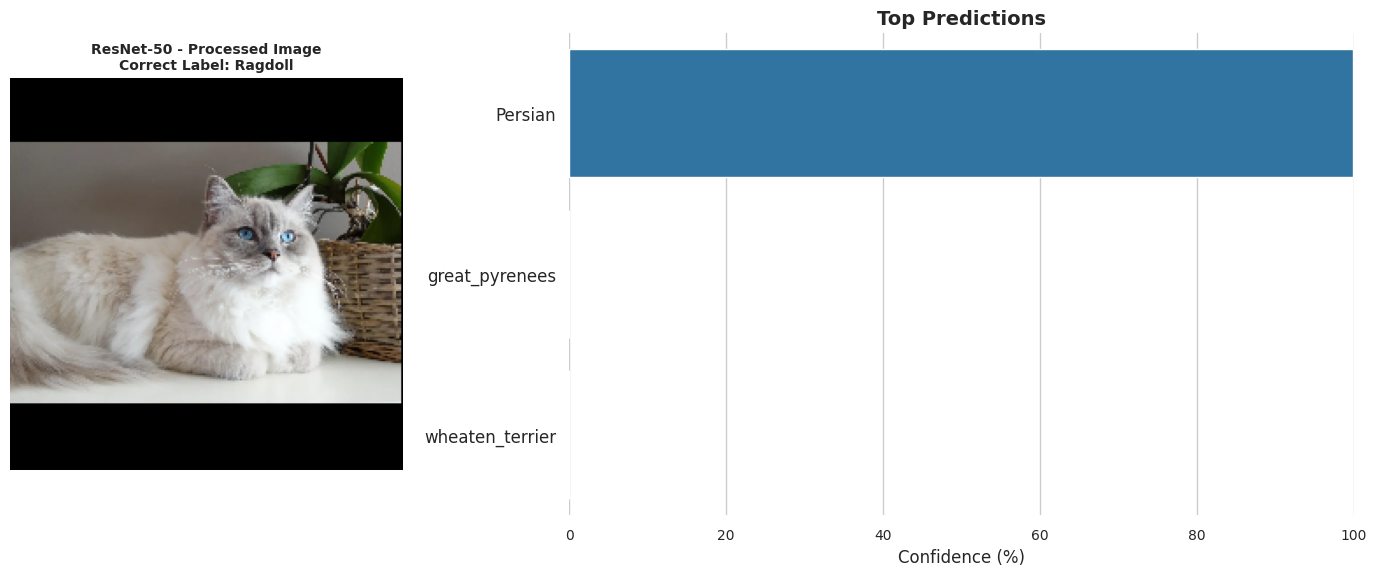

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


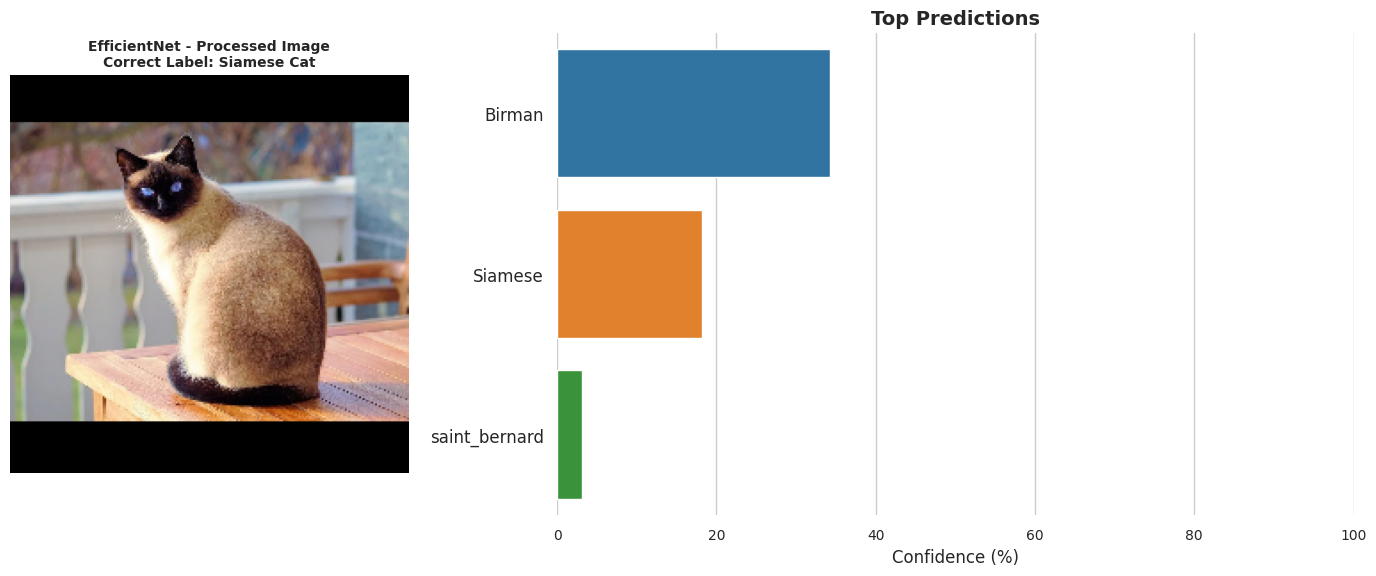

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


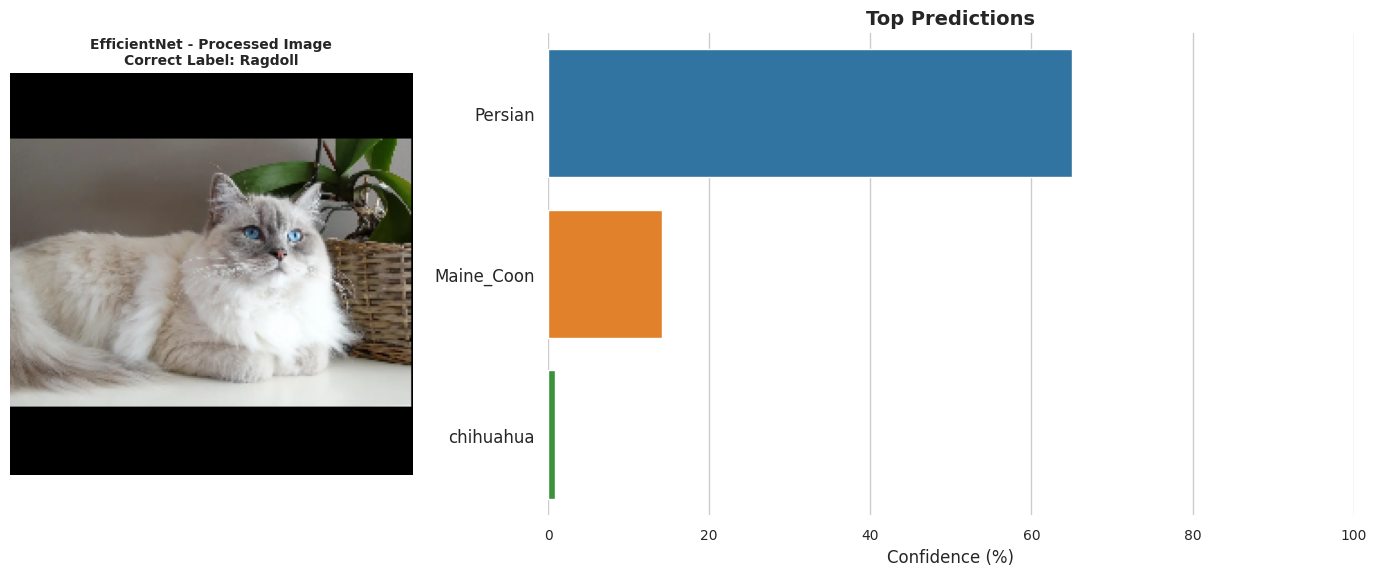

In [ ]:
for model_name, model_path in model_paths.items():
    try:
        model = load_model(model_path)

        predict_on_real_data(model, label_names,model_name )

    except Exception as e:
        print(f"Failed to process {model_name}: {e}")